# Aprendizado de Máquina - T2 - PPGCC 2024/2

Grupo 11 | Rafael Almeida de Bem

General objective: train a model to predict the survival of passengers on a cruise ship.

Instead of focusing on false positives, the goal is to minimize false negatives (recall).
That is, the model should be able to predict as many survivors as possible, even if it means predicting some non-survivors as survivors.


In [1]:
DATASET_FILE = "treino.csv"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import display

sns.set_style("darkgrid")

---

# Exploratory Data Analysis

In [3]:
df_orig = pd.read_csv(DATASET_FILE)

Check for missing values and data types.

In [4]:
def pprint_df(df: pd.DataFrame):
    def get_width(values: pd.Series, header: str):
        max_value_width = max(len(str(val)) for val in values)
        return max(max_value_width, len(header))

    headers = {
        'column': 'COLUMN NAME',
        'dtype': 'DATA TYPE',
        'missing': 'MISSING VALUES',
        'unique': 'UNIQUE VALUES',
    }

    data = {
        'column': df.columns,
        'dtype': df.dtypes,
        'missing': df.isnull().sum(),
        'unique': [df[col].nunique() for col in df.columns],
    }

    widths = {col: get_width(values, headers[col])
              for col, values in data.items()}

    separator = '+' + '+'.join('-' * (w + 2) for w in widths.values()) + '+'
    print(separator)
    print('| ' + ' | '.join(f"{headers[col]:^{widths[col]}}"
                            for col in data.keys()) + ' |')
    print(separator)
    for i in range(len(df.columns)):
        print('| ' + ' | '.join(
            f"{str(data[col][i]):<{widths[col]}}" if col == 'column'
            else f"{str(data[col][i]):>{widths[col]}}"
            for col in data.keys()
        ) + ' |')
    print(separator)


def plot_cat_dist(df: pd.DataFrame, col: str):
    plt.figure(figsize=(12, 10))
    df_sorted = df.sort_values(by=col)
    sns.barplot(data=df_sorted, x=col, y='Sobrevivente')
    plt.title(f'Survival Rate by {col}')
    plt.xticks(rotation=45)
    plt.show()

def plot_num_dist(df, col: str, *, extra_title: str = ''):
    plt.figure(figsize=(12, 10))
    sns.histplot(data=df, x=col, hue='Sobrevivente', kde=True, multiple='layer')
    plt.title(f'Distribution of {col} by Survival{extra_title}')
    plt.show()

In [5]:
pprint_df(df_orig)

+---------------+-----------+----------------+---------------+
|  COLUMN NAME  | DATA TYPE | MISSING VALUES | UNIQUE VALUES |
+---------------+-----------+----------------+---------------+
| IDpassageiro  |    object |              0 |          7124 |
| Nome          |    object |              0 |          7110 |
| Deck          |    object |              0 |             8 |
| NumeroCabine  |     int64 |              0 |          1769 |
| PosicaoCabine |    object |              0 |             2 |
| Procedencia   |    object |              0 |             4 |
| Destino       |    object |              0 |             4 |
| Idade         |   float64 |              0 |            80 |
| VIP           |     int64 |              0 |             2 |
| AllInclusive  |     int64 |              0 |             2 |
| ServicoCabine |   float64 |              0 |          1128 |
| Restaurante   |   float64 |              0 |          1327 |
| Shopping      |   float64 |              0 |         

In [6]:
df_orig.head()

IDpassageiro                Nome Deck  NumeroCabine PosicaoCabine  \
0      5647_02   Chabih Matoltuble    C           178             P   
1      0107_01         Coobix Hart    D             2             S   
2      4158_01        Doryn Noeley    E           273             S   
3      1316_01      Sadrus Quelfly    E            95             S   
4      9069_05  Mirfark Taketiatim    B           297             P   

  Procedencia Destino  Idade  VIP  AllInclusive  ServicoCabine  Restaurante  \
0     America  Monaco   52.0    0             0            0.0       1425.0   
1      Africa  Grecia   21.0    0             0         1743.0          5.0   
2      Europa  Grecia   27.0    0             0            0.0          0.0   
3     America  Grecia   28.0    0             1            0.0          0.0   
4     America  Monaco   29.0    0             0            0.0      12563.0   

   Shopping    SPA  ParquedeAguas  Sobrevivente  
0      31.0    0.0         1320.0             1  
1      17.0    0.0            0.0             0  
2     580.0  211.0            0.0             0  
3       0.0    0.0            0.0             1  
4       0.0    3.0         5057.0             0

In [7]:
df = df_orig.drop(columns=['IDpassageiro', 'Nome'], errors='ignore')
df.head()

Deck  NumeroCabine PosicaoCabine Procedencia Destino  Idade  VIP  \
0    C           178             P     America  Monaco   52.0    0   
1    D             2             S      Africa  Grecia   21.0    0   
2    E           273             S      Europa  Grecia   27.0    0   
3    E            95             S     America  Grecia   28.0    0   
4    B           297             P     America  Monaco   29.0    0   

   AllInclusive  ServicoCabine  Restaurante  Shopping    SPA  ParquedeAguas  \
0             0            0.0       1425.0      31.0    0.0         1320.0   
1             0         1743.0          5.0      17.0    0.0            0.0   
2             0            0.0          0.0     580.0  211.0            0.0   
3             1            0.0          0.0       0.0    0.0            0.0   
4             0            0.0      12563.0       0.0    3.0         5057.0   

   Sobrevivente  
0             1  
1             0  
2             0  
3             1  
4             0

Check for the distribution of the target variable (`Sobrevivente`).

In [8]:
df['Sobrevivente'].value_counts(normalize=True)

1    0.506457
0    0.493543
Name: Sobrevivente, dtype: float64

In [9]:
df.select_dtypes(include='number').columns

Index(['NumeroCabine', 'Idade', 'VIP', 'AllInclusive', 'ServicoCabine',
       'Restaurante', 'Shopping', 'SPA', 'ParquedeAguas', 'Sobrevivente'],
      dtype='object')

In [10]:
run_once = True

In [11]:
if run_once:
    df['GroupID'] = df_orig['IDpassageiro'].str.split('_').str[0]
    df = df.merge(df.groupby('GroupID').size().reset_index(name='GroupCount'), on='GroupID', how='left')
    df['IsSolo'] = (df['GroupCount'] == 1).astype(bool)
run_once = False

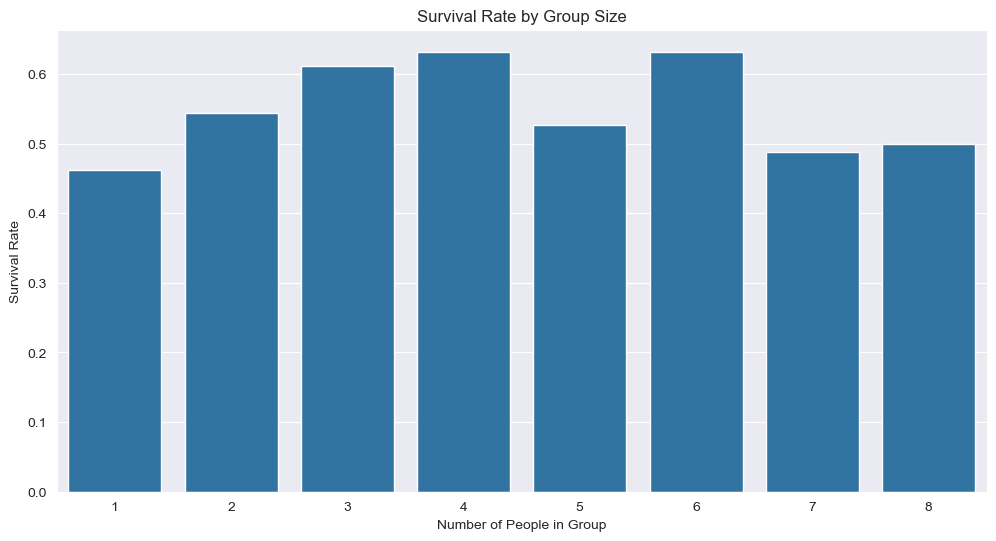

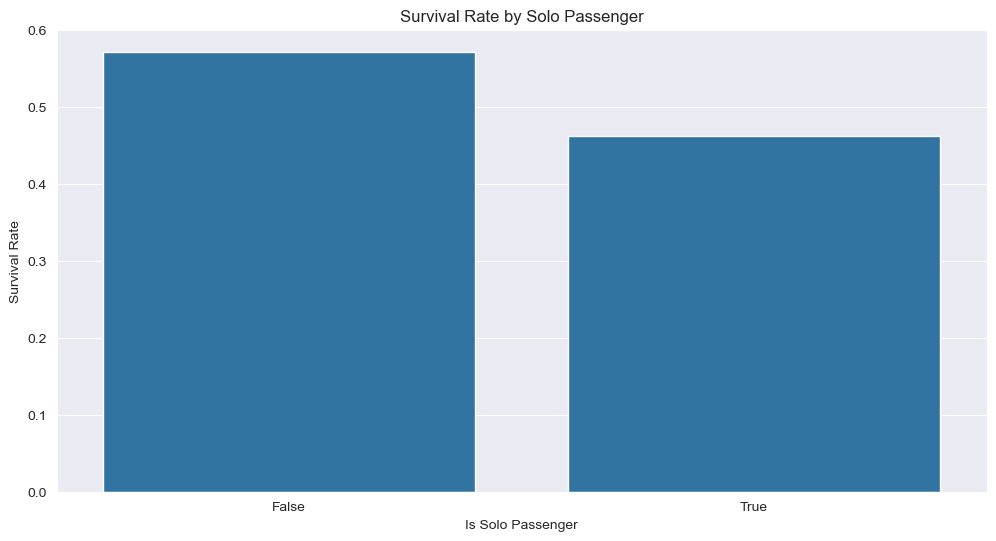

In [12]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df.groupby('GroupCount')['Sobrevivente'].agg(['mean', 'count']).reset_index(),
            x='GroupCount', y='mean')
plt.title('Survival Rate by Group Size')
plt.xlabel('Number of People in Group')
plt.ylabel('Survival Rate')
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(data=df.groupby('IsSolo')['Sobrevivente'].agg(['mean', 'count']).reset_index(),
            x='IsSolo', y='mean')
plt.title('Survival Rate by Solo Passenger')
plt.xlabel('Is Solo Passenger')
plt.ylabel('Survival Rate')
plt.show()

The following plot tells an interesting story about the data.
Kids (ages 0-10) seem to have a higher survival rate than other age groups, and young adults (ages 20-30) seem to have a lower survival rate.

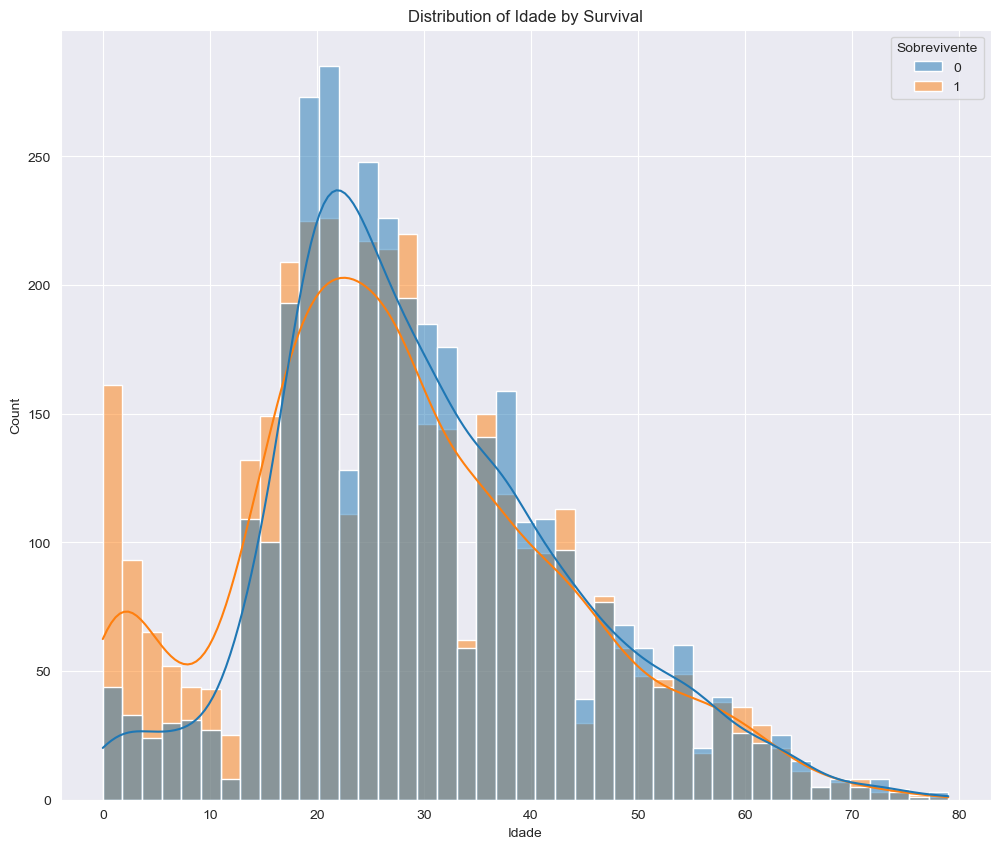

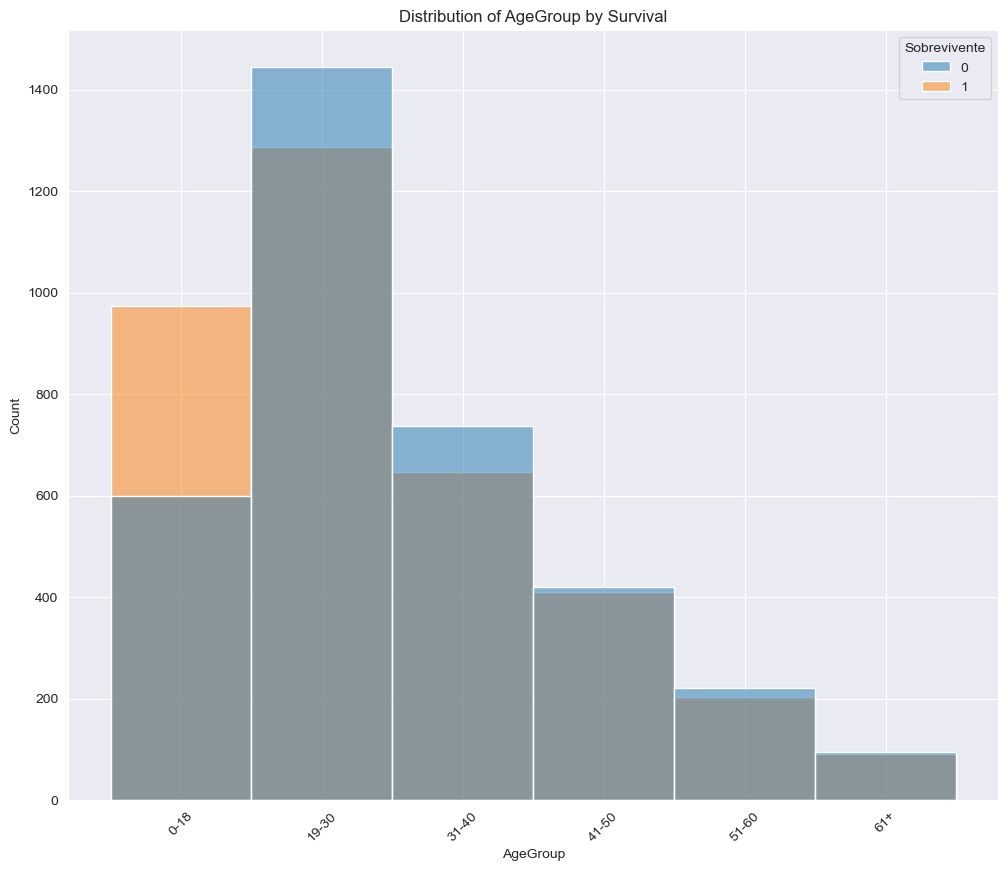

In [13]:
plot_num_dist(df, 'Idade')

df['AgeGroup'] = pd.cut(df['Idade'], bins=[-np.inf, 18, 30, 40, 50, 60, np.inf], labels=['0-18', '19-30', '31-40', '41-50', '51-60', '61+'])
plt.figure(figsize=(12, 10))
sns.histplot(data=df, x='AgeGroup', hue='Sobrevivente', multiple='layer')
plt.title('Distribution of AgeGroup by Survival')
plt.xticks(rotation=45)
plt.show()

<Figure size 1000x800 with 0 Axes>

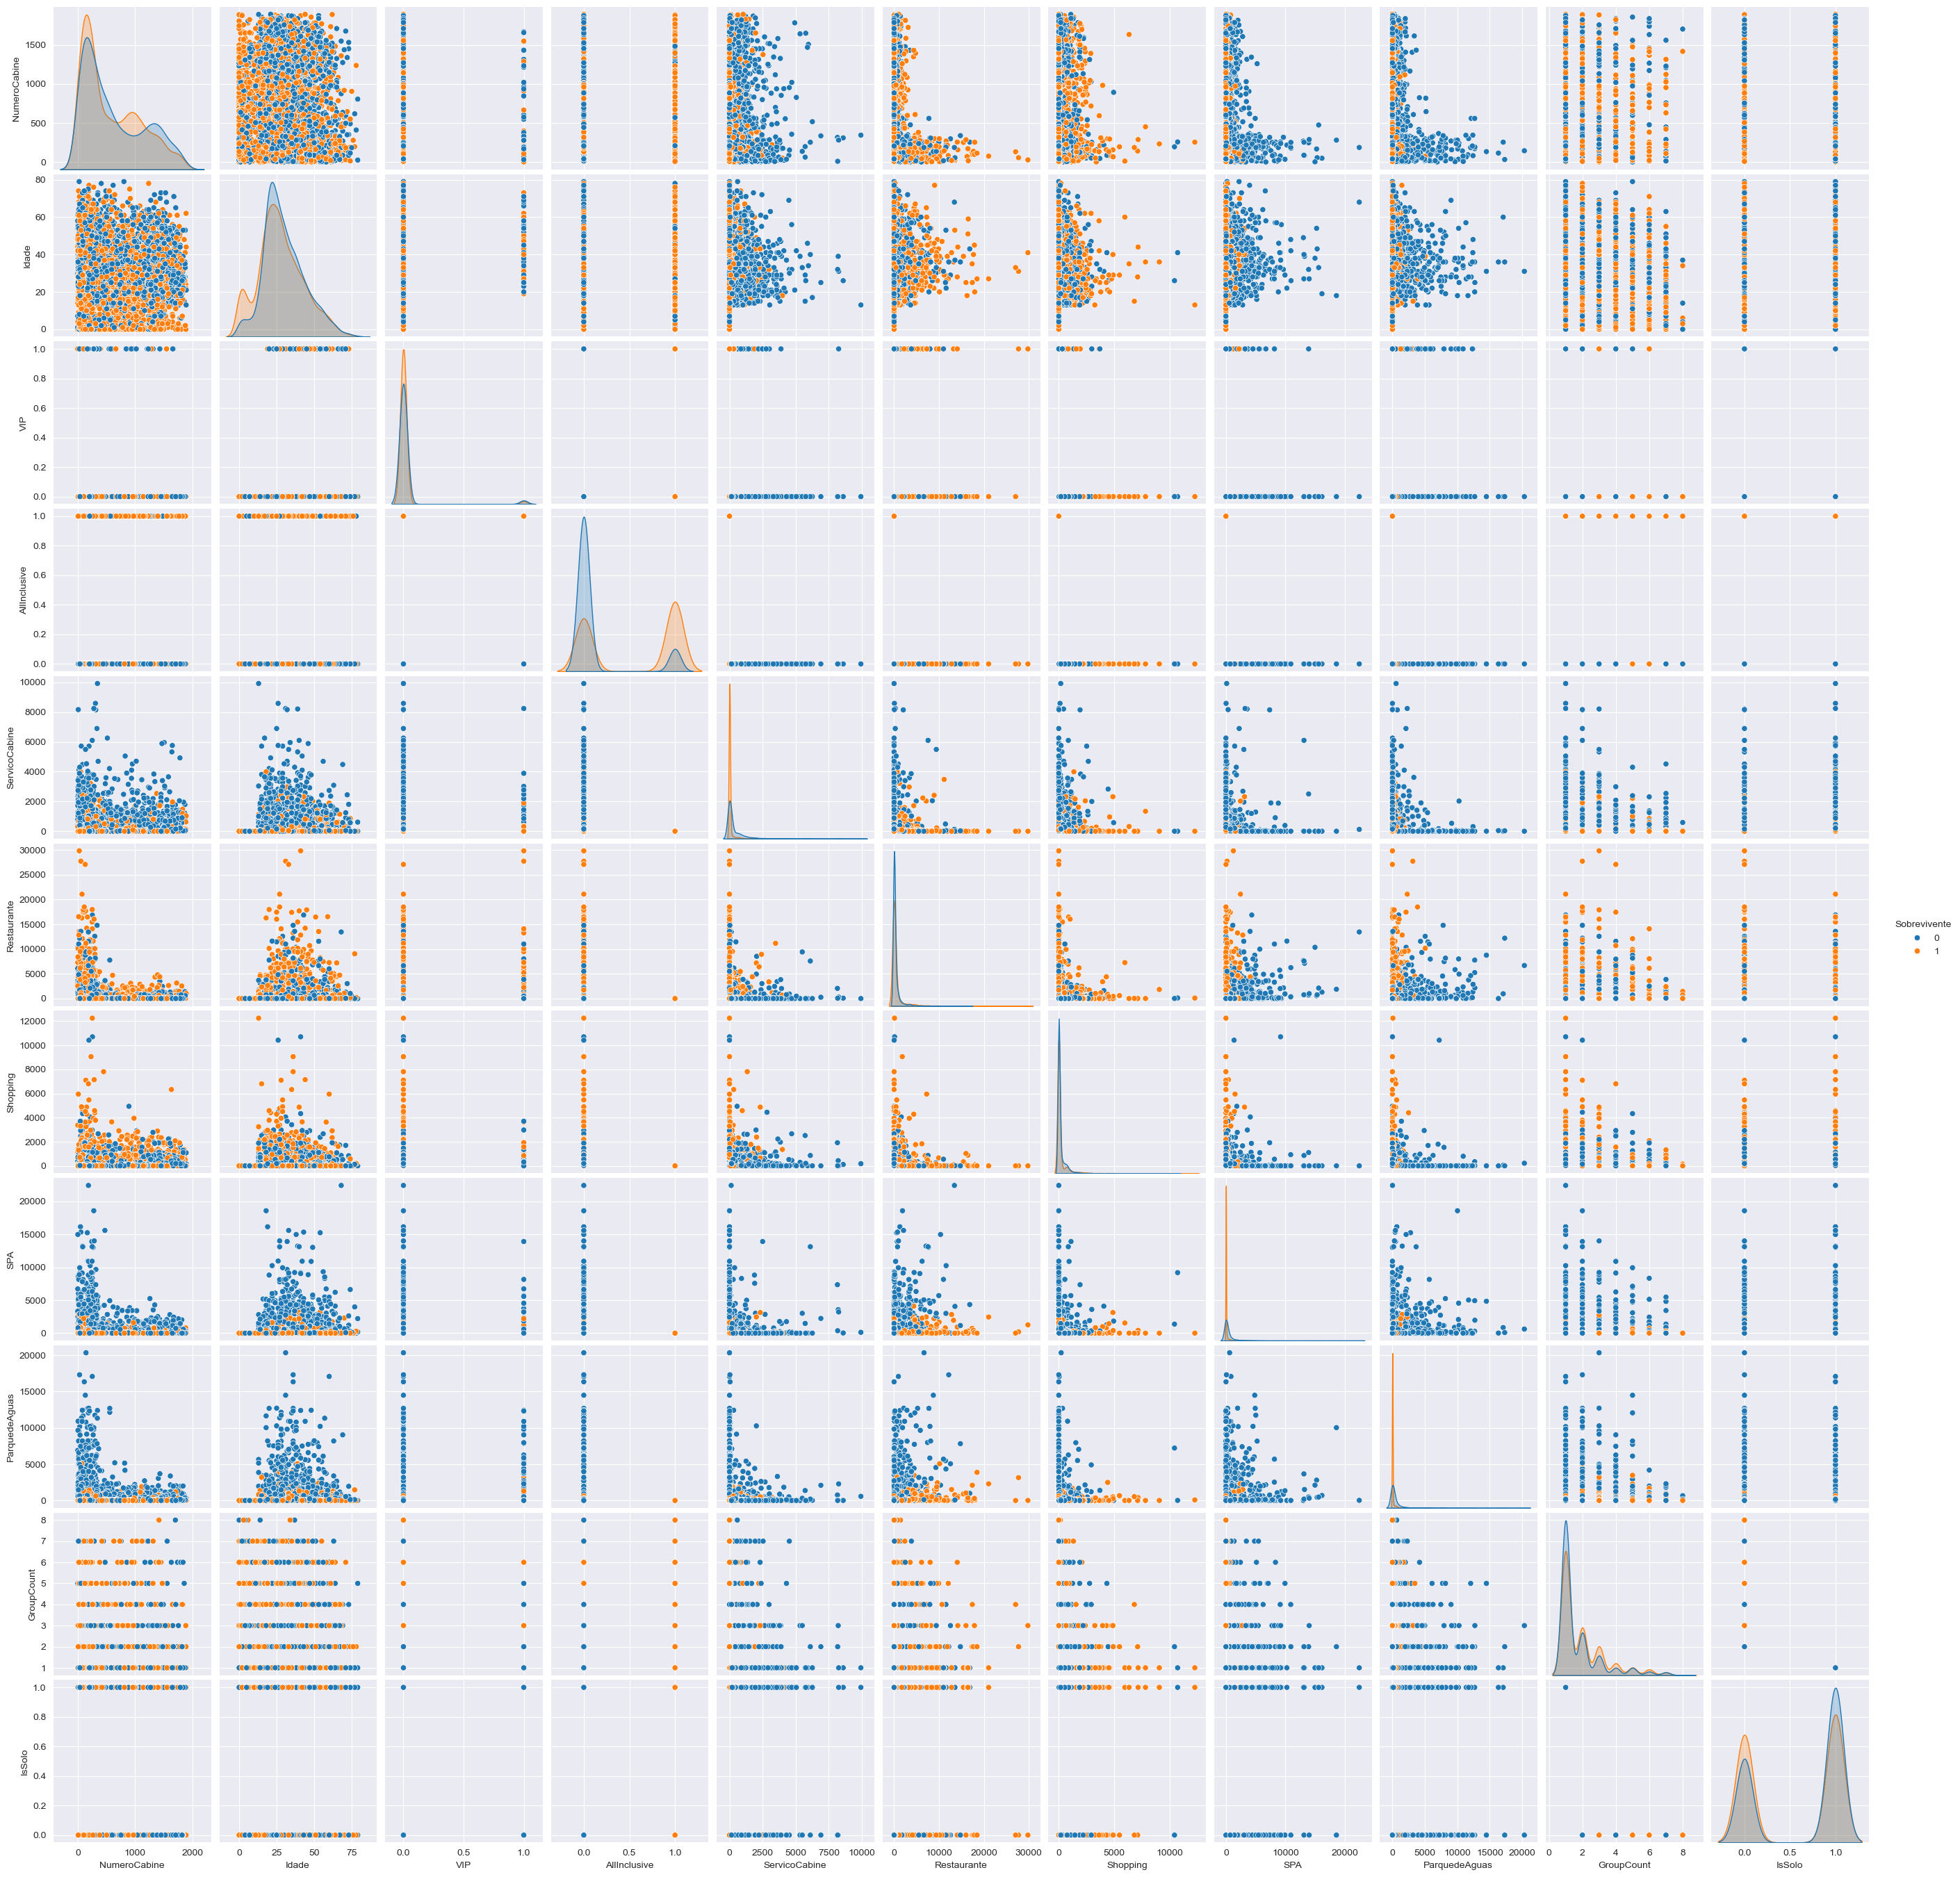

In [14]:
plt.figure(figsize=(10, 8))
sns.pairplot(df, hue='Sobrevivente')
plt.show()

Now I went on to explore the relationship between the target variable and the other variables per deck.
My hypothesis is that the deck where the passenger was located and their cabin position (i.e. `NumeroCabine`) could have influenced the survival rate, and that seems hold some truth.

Decks B and C have a higher survival rate, while decks D, E and T have a lower survival rate. Deck T is a special case as it has only a few samples (4), so I wouldn't trust the results for this deck.

This analysis makes me feel like some data augmentation could be done to add context, e.g. by one-hot encoding the passenger's deck.

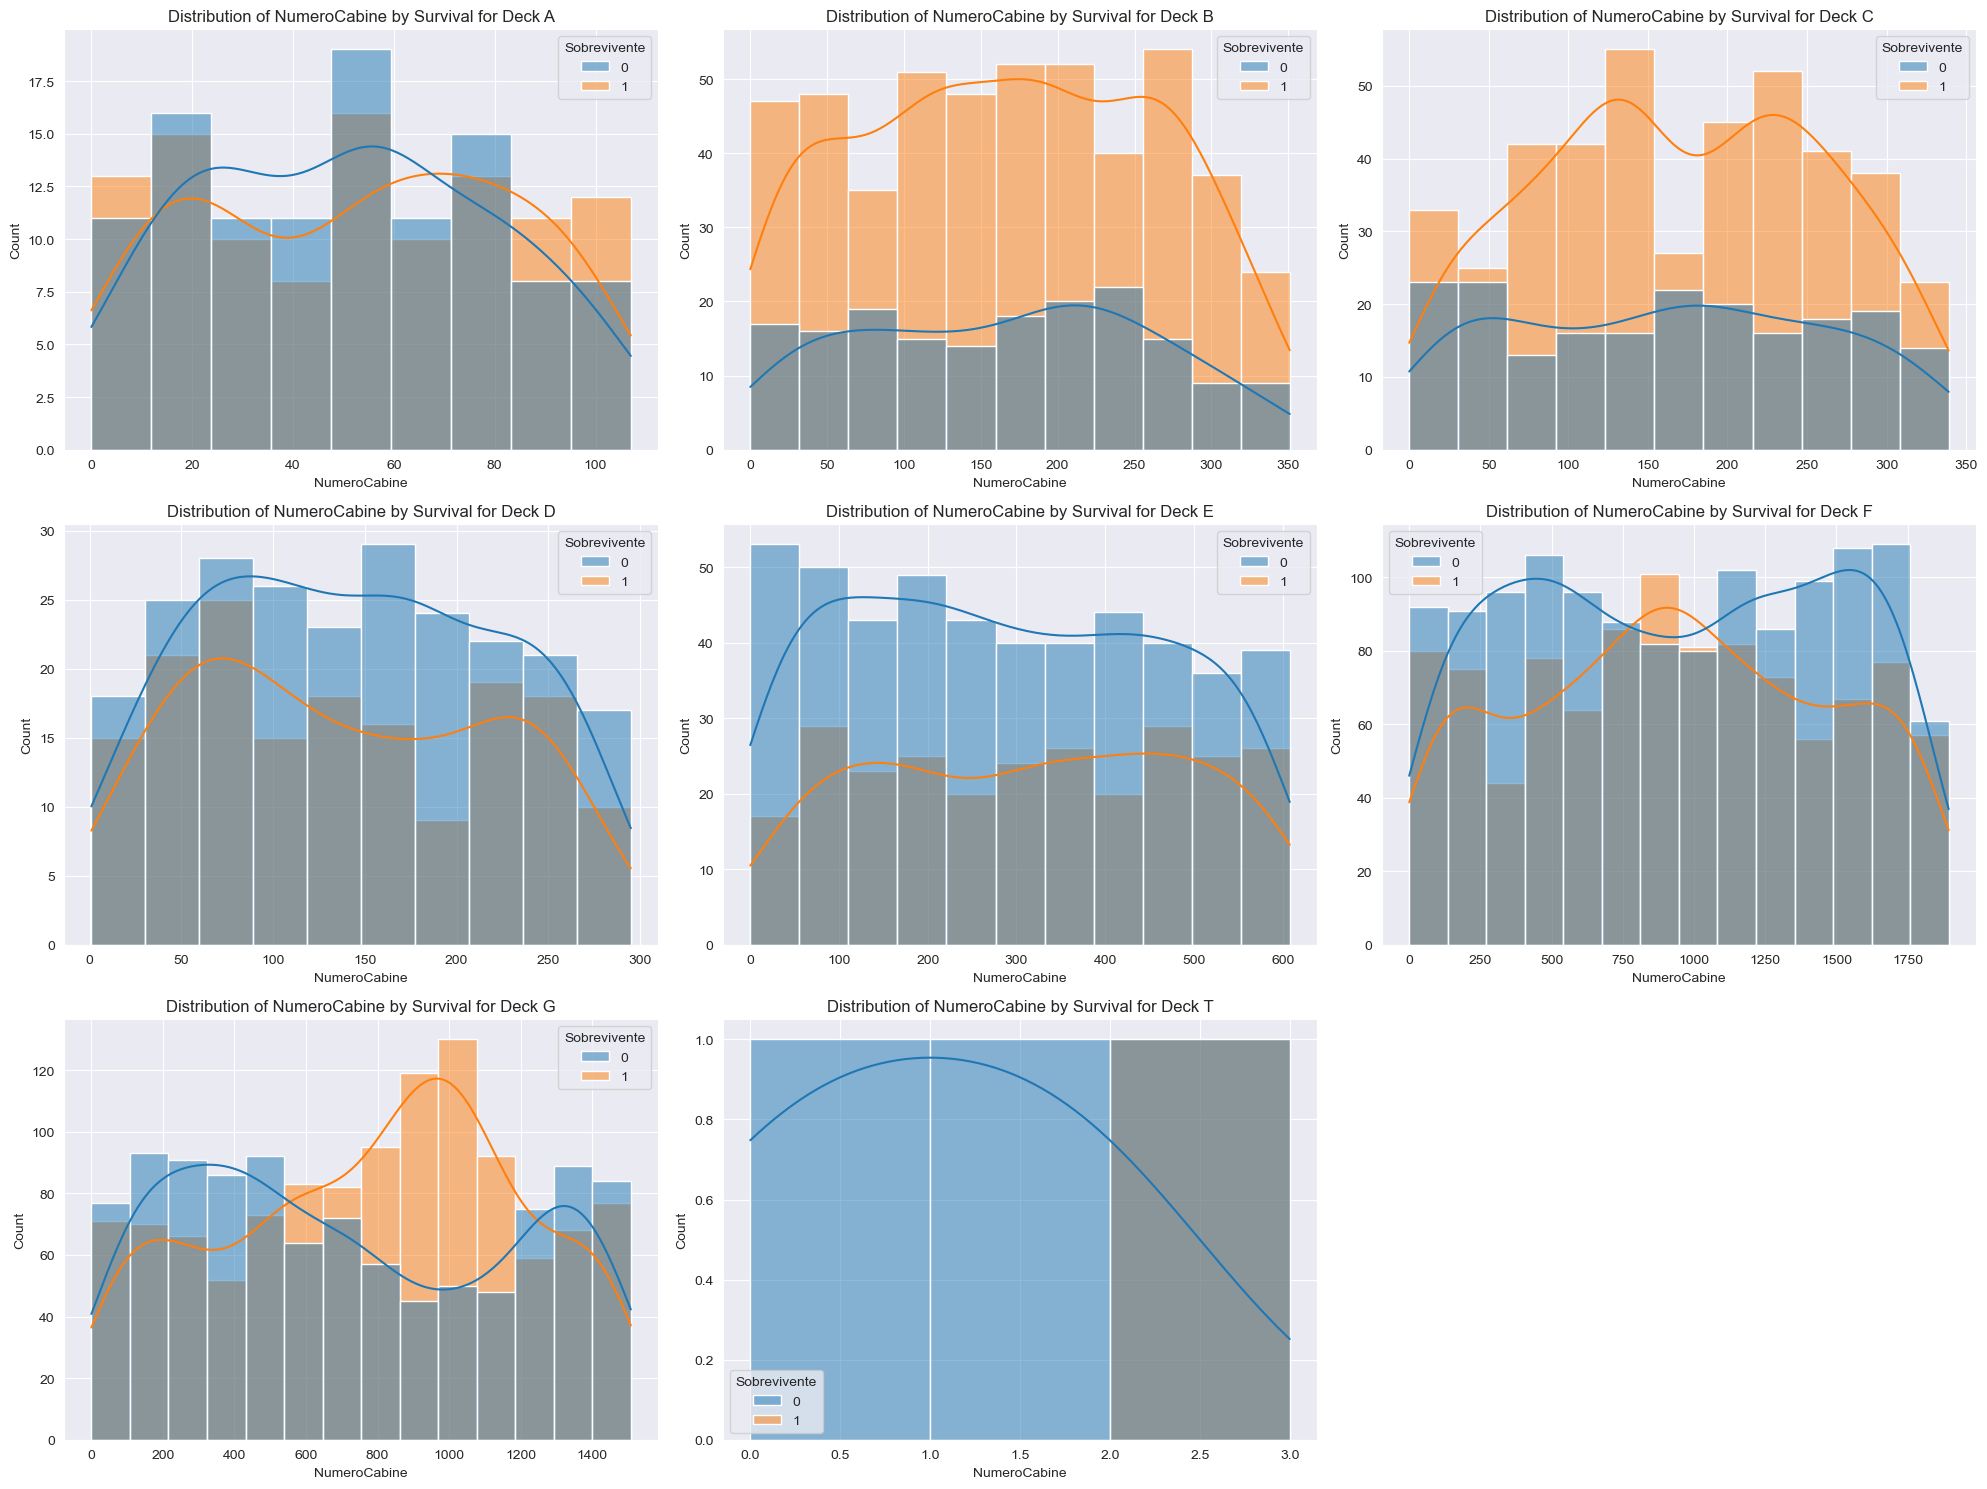

In [15]:
decks = sorted(df['Deck'].unique())
n_rows = (len(decks) + 1) // 3
fig, axes = plt.subplots(n_rows, 3, figsize=(20, 5 * n_rows))
axes = axes.flatten()
for i, deck in enumerate(decks):
    deck_data = df[df.Deck == deck]
    sns.histplot(data=deck_data, x='NumeroCabine', hue='Sobrevivente', kde=True, multiple='layer', ax=axes[i])
    axes[i].set_title(f'Distribution of NumeroCabine by Survival for Deck {deck}')
if len(decks) % 3 != 0:
    fig.delaxes(axes[-1])
plt.tight_layout()
plt.show()

Now I also wanted to verify if there was any relation between the survavility and age per deck.

As previously observed, kids have a higher survival rate than other age groups, and young adults have a lower survival rate.
Also, passengers in decks B and C have a higher survival rate, while passengers in decks D, E and T have a lower survival rate.

If you're a kid in deck B or C, you're probably in a good spot.
Rather, if you're in deck B or C you're probably in a good spot, regardless of your age.

If you're a kid in deck E, you're similar to the average passenger in deck E - you're not in a good spot.

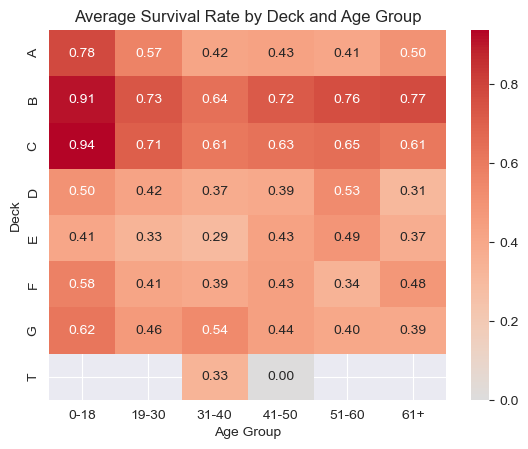

In [16]:
# use the same bins as the AgeGroup and then split per deck
ct = pd.crosstab(df['Deck'], df['AgeGroup'], values=df['Sobrevivente'], aggfunc='mean')
sns.heatmap(ct, annot=True, cmap='coolwarm', fmt='.2f', center=0)
plt.title('Average Survival Rate by Deck and Age Group')
plt.xlabel('Age Group')
plt.ylabel('Deck')
plt.show()

The following plots show the Survival Rate (%) of a few different columns.

Notable observations:
- Passengers in decks B and C have a higher survival rate
- The survival rate increases drastically (over 140%) for passengers that opted for the `AllInclusive` package
- VIP passengers have a lower survival rate (around 20% decrease)

Some other interesting observations:
- Origin and destination

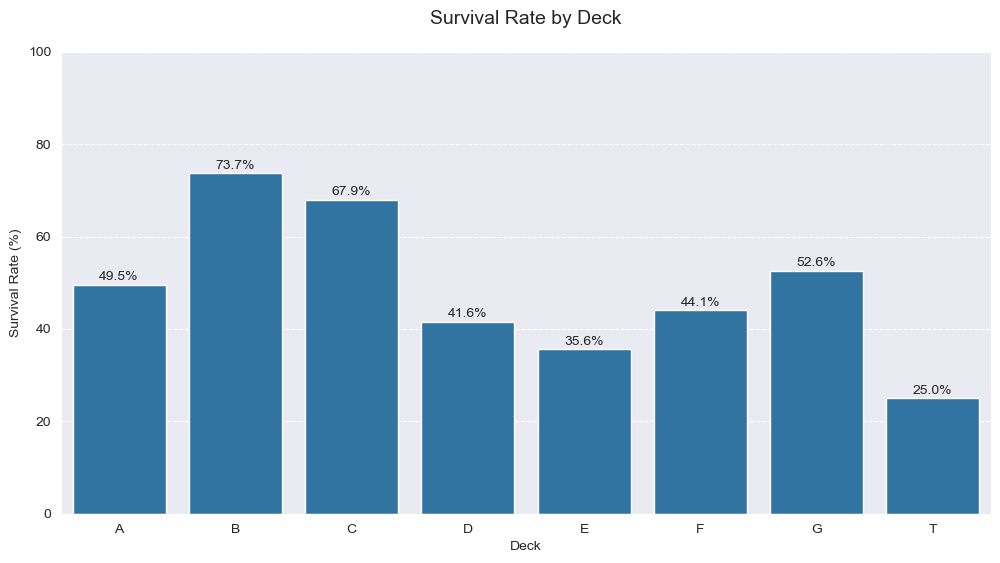

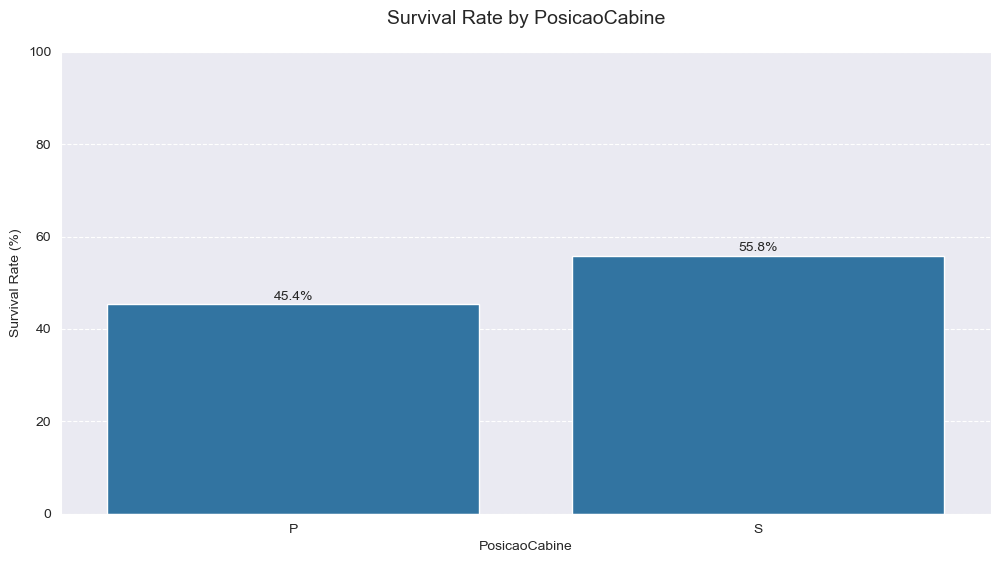

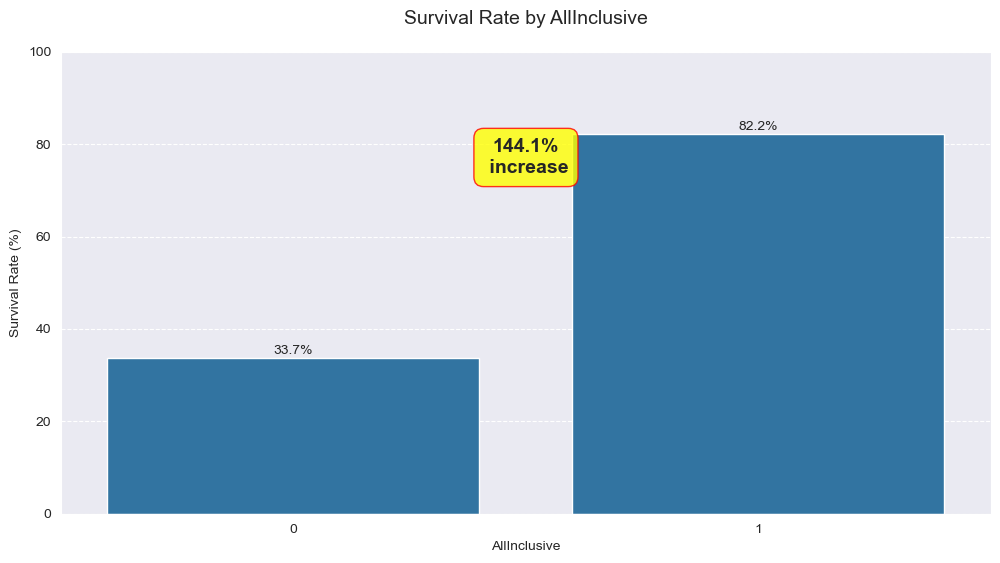

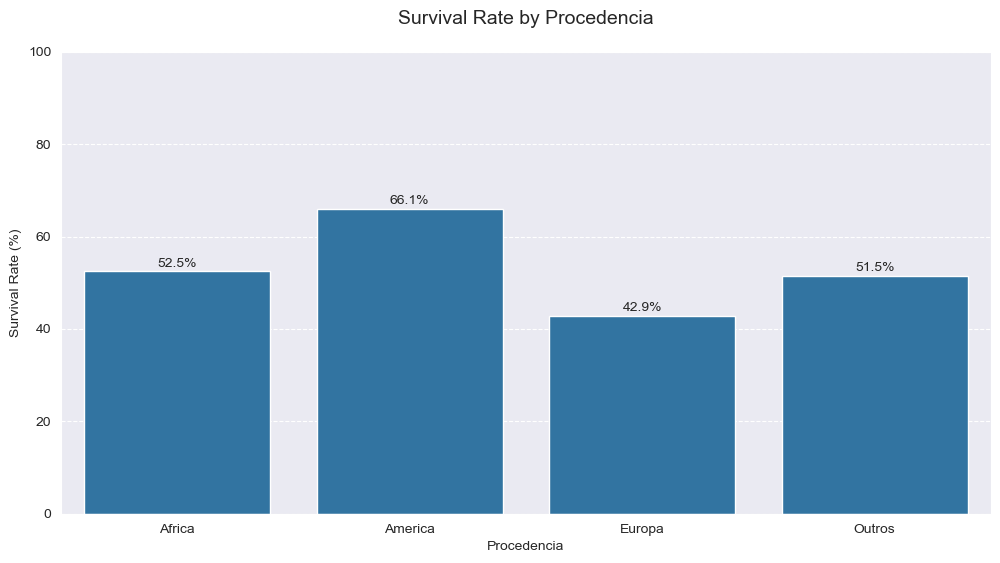

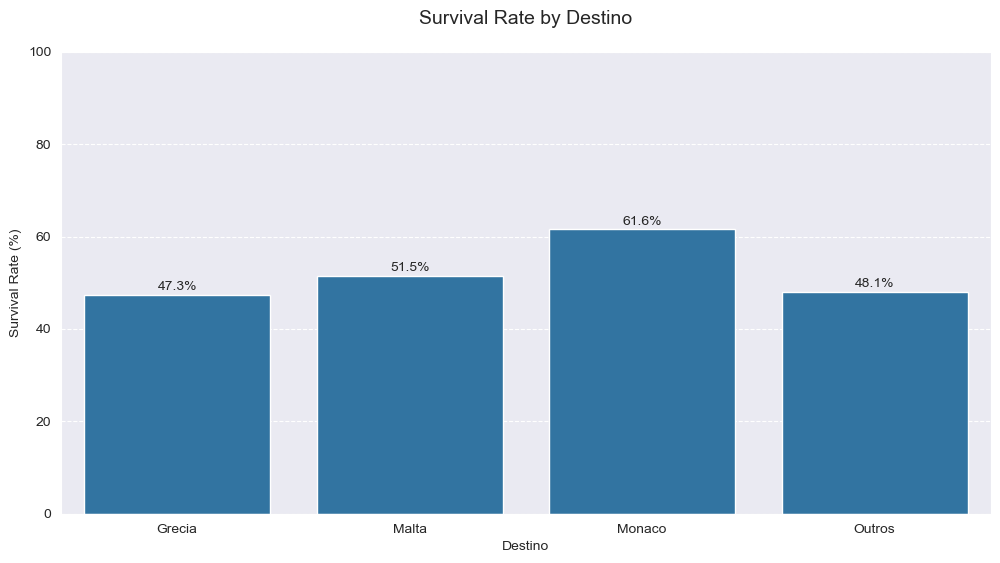

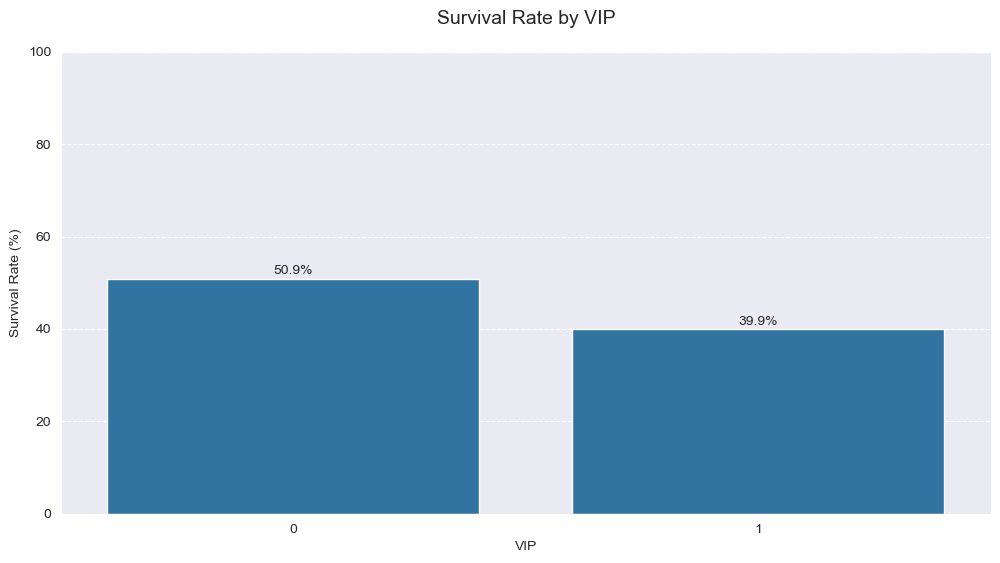

In [17]:
for target_col in ['Deck', 'PosicaoCabine', 'AllInclusive', 'Procedencia', 'Destino', 'VIP']:
    deck_survival = df.groupby(target_col)[
        'Sobrevivente'].agg(['count', 'mean'])
    deck_survival['mean'] = deck_survival['mean'] * 100

    plt.figure(figsize=(12, 6))
    sns.barplot(data=deck_survival, x=target_col, y='mean')
    plt.title(f'Survival Rate by {target_col}', pad=20, fontsize=14)
    plt.xlabel(target_col)
    plt.ylabel('Survival Rate (%)')

    for i, v in enumerate(deck_survival['mean']):
        plt.text(i, v + 1, f'{v:.1f}%', ha='center')

    if target_col == 'AllInclusive':
        pct_increase = ((deck_survival.loc[1, 'mean'] - deck_survival.loc[0, 'mean']) / deck_survival.loc[0, 'mean'] * 100)  # type: ignore

        plt.annotate(
            f'{pct_increase:.1f}%\n increase',
            xy=(0.5, (deck_survival.loc[0, 'mean'] + deck_survival.loc[1, 'mean'])/2),
            xytext=(0.5, (deck_survival.loc[0, 'mean'] + deck_survival.loc[1, 'mean'])/2 + 15),
            ha='center', va='bottom', fontsize=14, fontweight='bold', 
            bbox=dict(
                boxstyle='round,pad=0.5',
                fc='yellow',
                ec='red',
                alpha=0.8
            )
        )

    plt.ylim(0, 100)
    plt.grid(axis='y', linestyle='--')
    plt.show()

As we can see in the following heatmap, the `Shopping` column has such a low correlation with the target variable that it can be considered irrelevant.
Thus, we can drop this column.

It's also worth noting that the `AllInclusive` column has a high correlation with the target variable, which suggests that it may be an important feature.

The `ServicoCabine`, `SPA` and `ParquedeAguas` columns also have a notable correlation with the target variable, although not as high as the `AllInclusive` column.

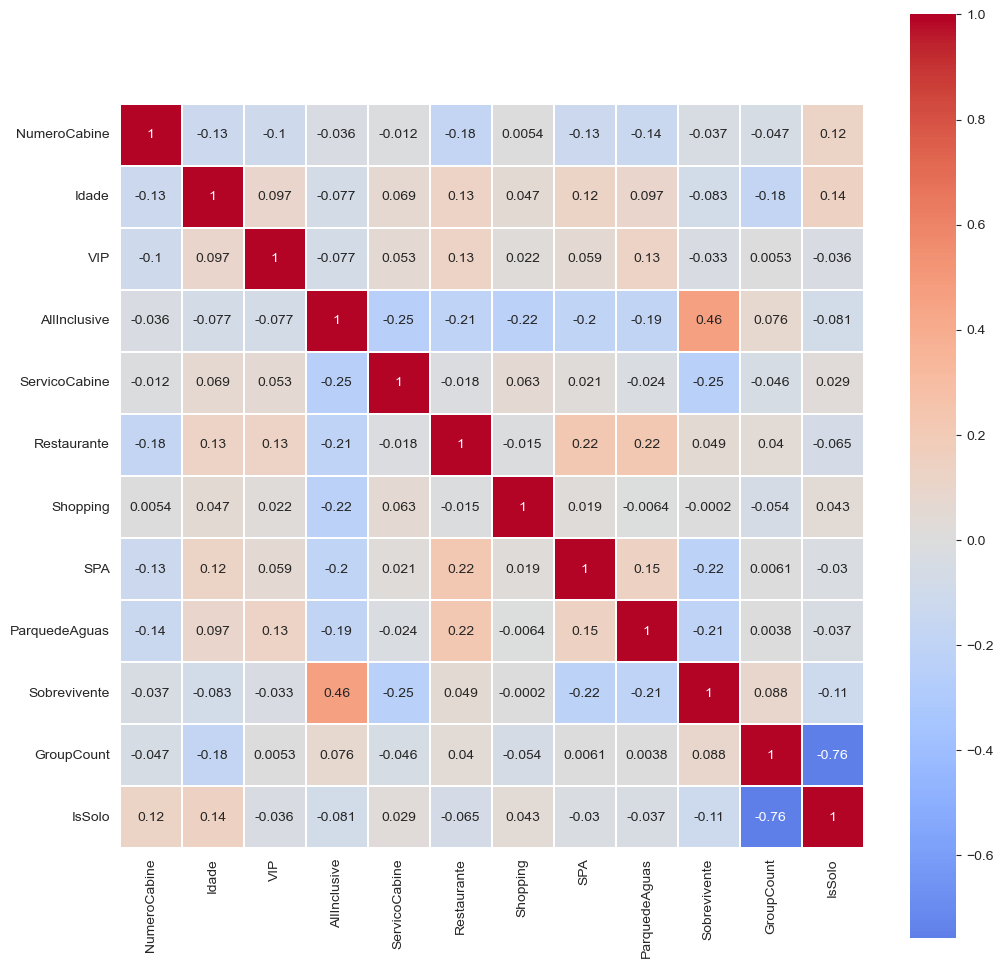

ServicoCabine   -0.246416
SPA             -0.218608
ParquedeAguas   -0.207996
Idade           -0.083369
NumeroCabine    -0.037309
VIP             -0.033461
Shopping        -0.000201
Restaurante      0.048750
GroupCount       0.087884
AllInclusive     0.462834
Sobrevivente     1.000000
Name: Sobrevivente, dtype: float64


In [18]:
plt.figure(figsize=(12, 12))
sns.heatmap(df.corr(numeric_only=True), annot=True,
            cmap='coolwarm', center=0, square=True, linewidths=0.3)
plt.show()

(numeric_cols := df.select_dtypes(include=np.number).columns.tolist()).remove('Sobrevivente')
print(df[numeric_cols + ['Sobrevivente']].corr()['Sobrevivente'].sort_values())

Now let's add the categorical columns to the heatmap and see if we can find any interesting correlations.

We can see that even though the `Deck` column looked promising, it doesn't seem to have a high correlation with the target variable in the heatmap.
For example, there's zero correlation between the survival rate and passengers in Deck A.
The strongest correlation still seems to be with the `AllInclusive` column.

Other interesting observations:
- European passengers seem to prefer Deck G
- Americans seem to prefer Decks B and C and avoid Decks F and G
- Passengers destined for Greece seem to have a lower survival rate (-0.10 correlation, weak but still interesting)
- Passengers destined for Monaco seem to have a higher survival rate (0.11 correlation, also weak but interesting)
- While VIP status shows relatively weak correlations overall, there's a slight negative correlation with `AllInclusive` (-0.08), a slightly positive correlation with Deck A (0.12), a slightly positive correlation with American passengers (0.15), and a slightly negative correlation with European passengers (-0.17)
- Besides being strongly correlated to survival, `AllInclusive` passengers seem to have spent less on restaurants (-0.21), SPAs (-0.20), water parks (-0.19), shopping (-0.22) and also seem to avoid Deck F.

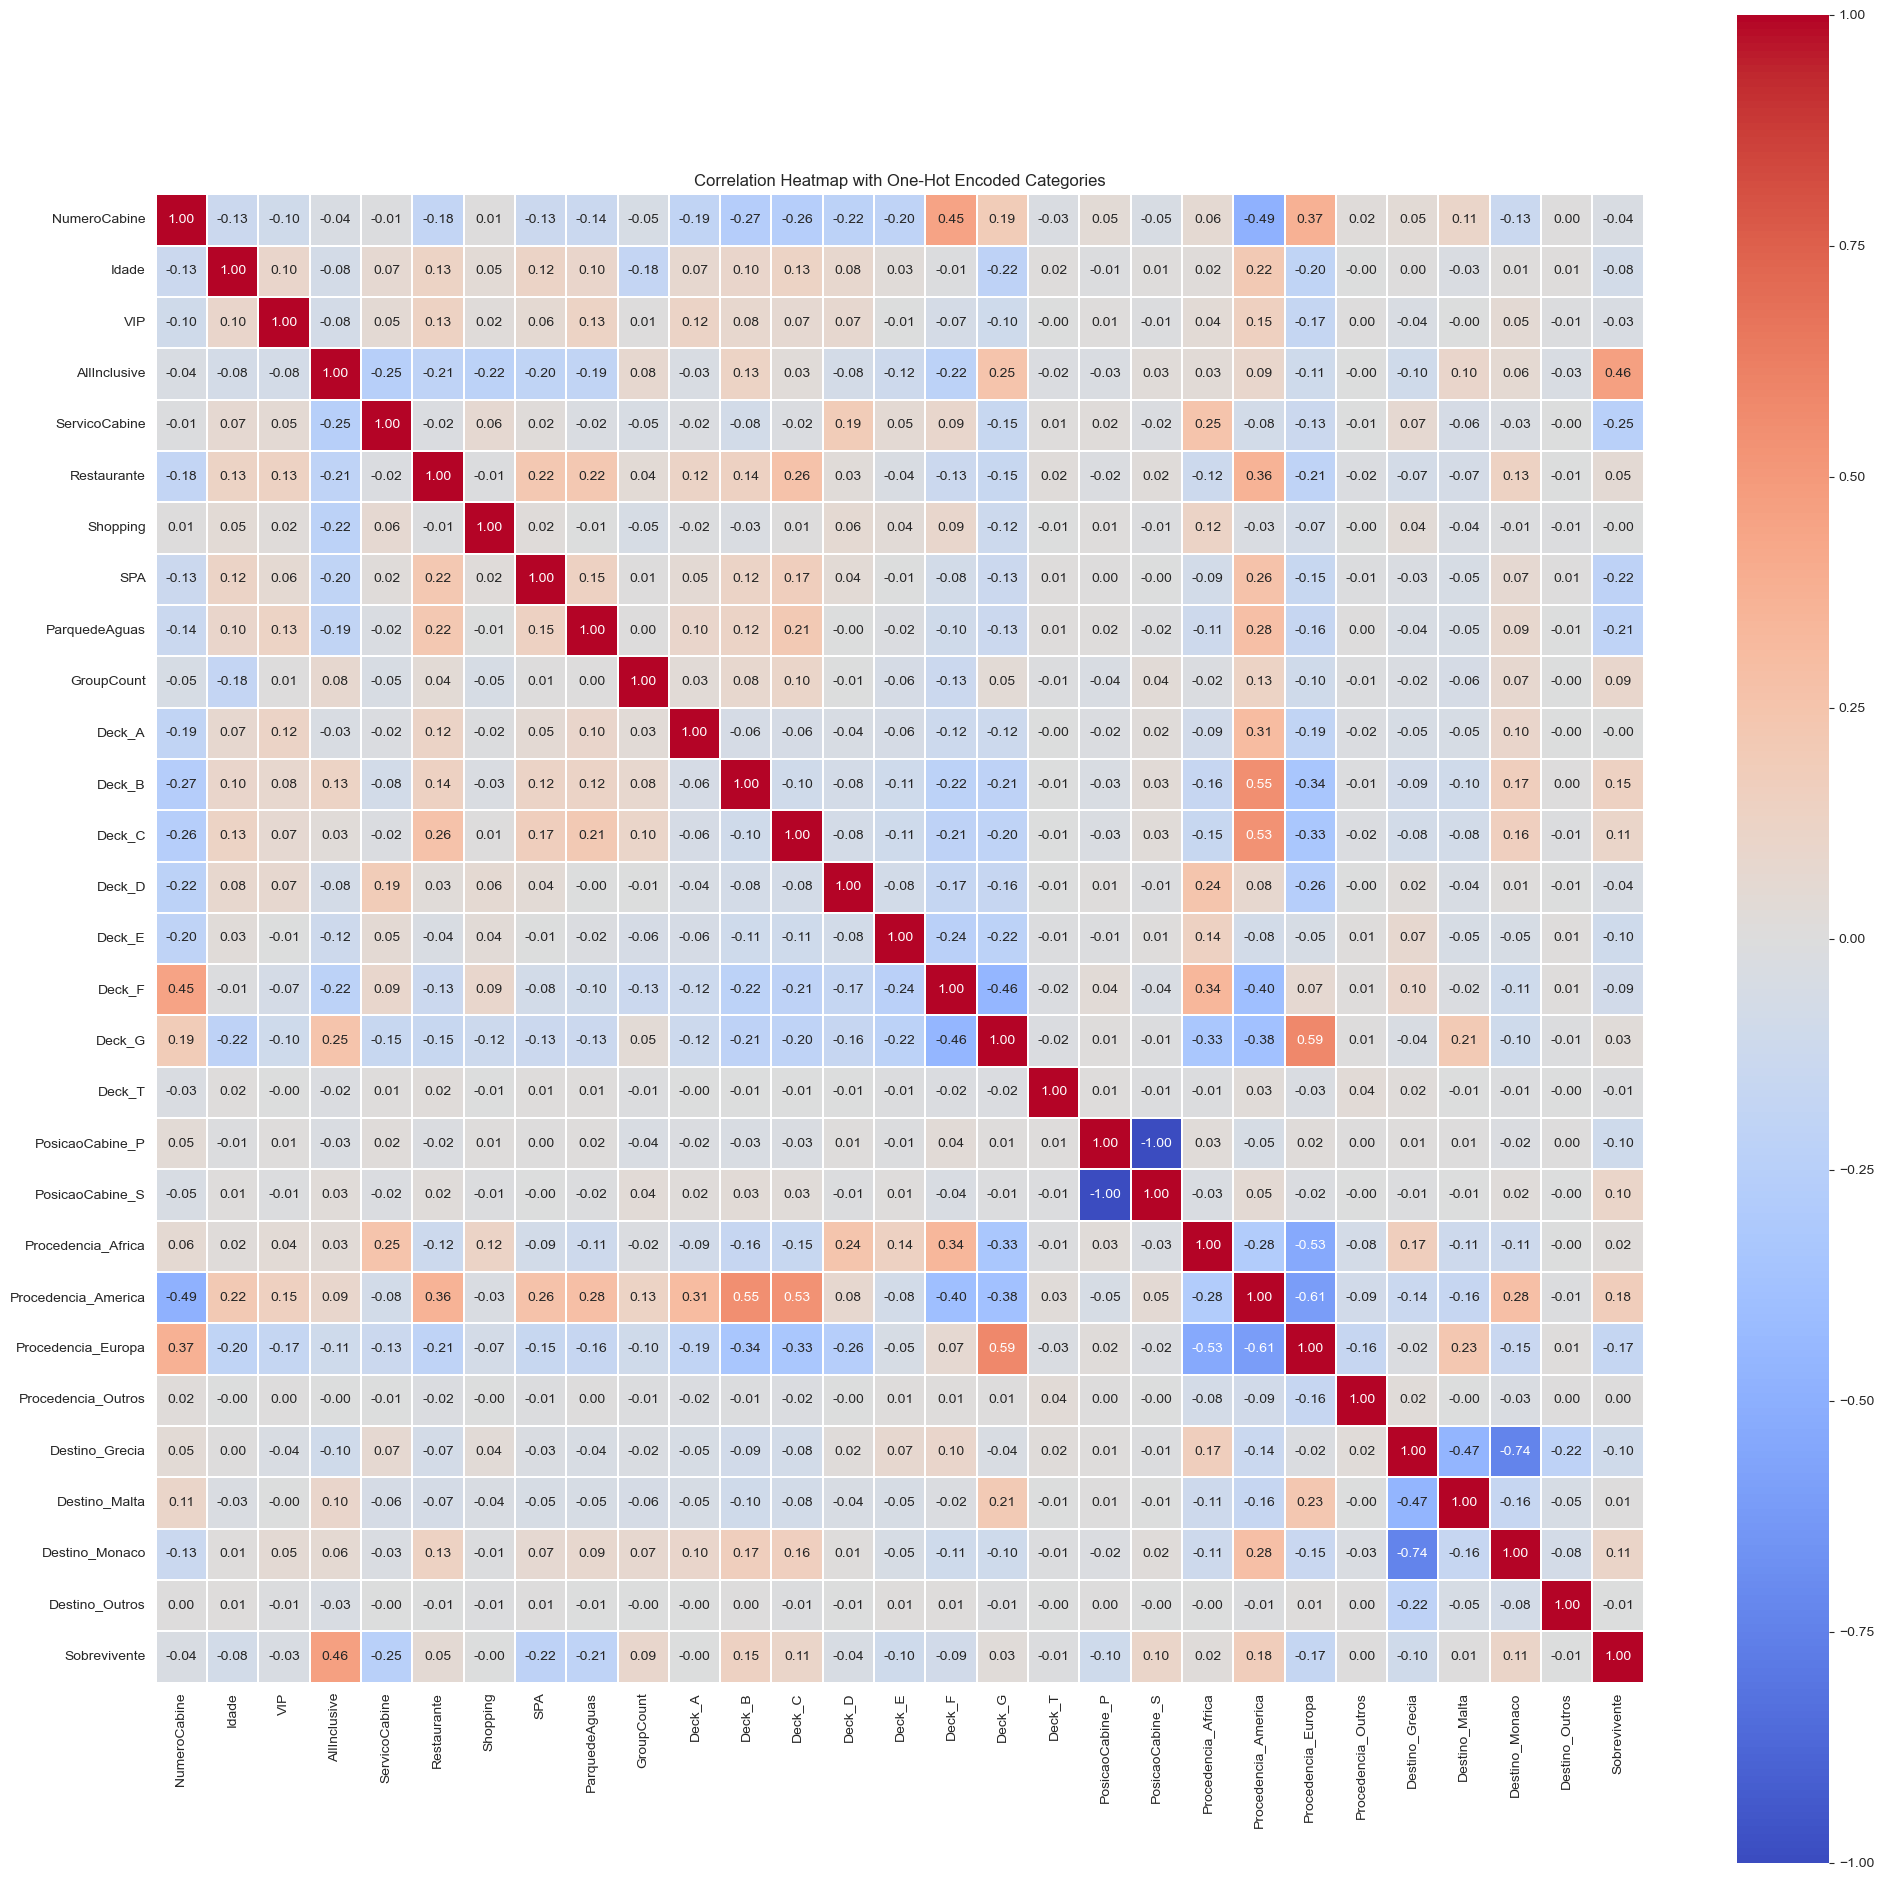

In [19]:
df_enc = df.copy()
df_enc = df_enc.drop(columns=['GroupID', 'IsSolo', 'AgeGroup'])
cat_cols = df_enc.select_dtypes(include=['object', 'category']).columns
for col in cat_cols:
    df_enc[col] = df_enc[col].astype('category').cat.codes
    one_hot = pd.get_dummies(df[col], prefix=col, prefix_sep='_')
    df_enc = df_enc.drop(columns=[col])
    df_enc = pd.concat([df_enc, one_hot], axis=1)
corr = df_enc.corr()
cols = [col for col in corr.columns if col != 'Sobrevivente'] + ['Sobrevivente']
corr = corr.loc[cols, cols]
plt.figure(figsize=(24, 24))
sns.heatmap(
    corr,
    annot=True,
    cmap='coolwarm',
    center=0,
    fmt='.2f',
    square=True,
    linewidths=0.3,
)
plt.title('Correlation Heatmap with One-Hot Encoded Categories')
plt.show()

Given the observations above, I would consider dropping the `Shopping` column and one-hot encoding the `Deck` and `Procedencia` columns.

There also seems to be some correlation between being an `AllInclusive` passenger and spending less on the other services, which makes sense.

---
# Feature Engineering

After running a few tests with different models, I was able to consistently achieve an F1 score of around 0.80.
I then decided to try a few feature engineering techniques to see if I could improve the models' performance.

Spoiler: I couldn't. This section is here for completeness' sake.
The heatmap below shows the correlation between the new features and the target variable.
It's visible that most of the new features don't have a high correlation with the target variable, so I decided to drop them.

In [20]:
df_aug = df.copy()

spending_cols = ['ServicoCabine', 'Restaurante', 'SPA', 'ParquedeAguas']
df_aug["TotalSpending"] = df_aug[spending_cols].sum(axis=1)

total_spending = df_aug['TotalSpending'].replace(0, 1)  # Avoid division by zero
for col in spending_cols:
    df_aug[f'{col}_Pct'] = df_aug[col] / total_spending * 100

# Premium passenger if they spent more than the average
df_aug["PremiumPassenger"] = (df_aug["TotalSpending"] > df_aug["TotalSpending"].mean()).astype(bool)

df_aug["HighSurvivalDeck"] = df_aug["Deck"].isin(['B', 'C']).astype(bool)
df_aug["LowSurvivalDeck"] = df_aug["Deck"].isin(['D', 'E', 'T']).astype(bool)

df_aug['Deck_PosicaoCabine'] = df['Deck'] + "_" + df['PosicaoCabine']

df_aug = df_aug.drop(columns=spending_cols + ['Idade', 'NumeroCabine', 'PosicaoCabine', 'Deck', 'GroupID', 'AgeGroup'], errors='ignore')

In [21]:
df_aug

Procedencia Destino  VIP  AllInclusive  Shopping  Sobrevivente  \
0        America  Monaco    0             0      31.0             1   
1         Africa  Grecia    0             0      17.0             0   
2         Europa  Grecia    0             0     580.0             0   
3        America  Grecia    0             1       0.0             1   
4        America  Monaco    0             0       0.0             0   
...          ...     ...  ...           ...       ...           ...   
7119      Africa  Grecia    0             0     891.0             0   
7120      Europa  Grecia    0             0     534.0             0   
7121      Africa  Outros    0             0      32.0             0   
7122      Africa  Monaco    0             0     172.0             0   
7123      Africa  Monaco    0             0     194.0             0   

      GroupCount  IsSolo  TotalSpending  ServicoCabine_Pct  Restaurante_Pct  \
0              3   False         2745.0           0.000000        51.912568   
1              1    True         1748.0          99.713959         0.286041   
2              1    True          211.0           0.000000         0.000000   
3              2   False            0.0           0.000000         0.000000   
4              3   False        17623.0           0.000000        71.287522   
...          ...     ...            ...                ...              ...   
7119           1    True          683.0          65.592972         0.000000   
7120           1    True          270.0         100.000000         0.000000   
7121           1    True          885.0         100.000000         0.000000   
7122           1    True         1814.0          11.190739         0.000000   
7123           4   False          880.0          16.931818         0.000000   

         SPA_Pct  ParquedeAguas_Pct  PremiumPassenger  HighSurvivalDeck  \
0       0.000000          48.087432              True              True   
1       0.000000           0.000000              True             False   
2     100.000000           0.000000             False             False   
3       0.000000           0.000000             False             False   
4       0.017023          28.695455              True              True   
...          ...                ...               ...               ...   
7119    0.000000          34.407028             False             False   
7120    0.000000           0.000000             False             False   
7121    0.000000           0.000000             False             False   
7122   80.485116           8.324146              True             False   
7123   83.068182           0.000000             False             False   

      LowSurvivalDeck Deck_PosicaoCabine  
0               False                C_P  
1                True                D_S  
2                True                E_S  
3                True                E_S  
4               False                B_P  
...               ...                ...  
7119            False                F_P  
7120            False                F_P  
7121             True                D_P  
7122            False                F_P  
7123            False                F_P  

[7124 rows x 17 columns]

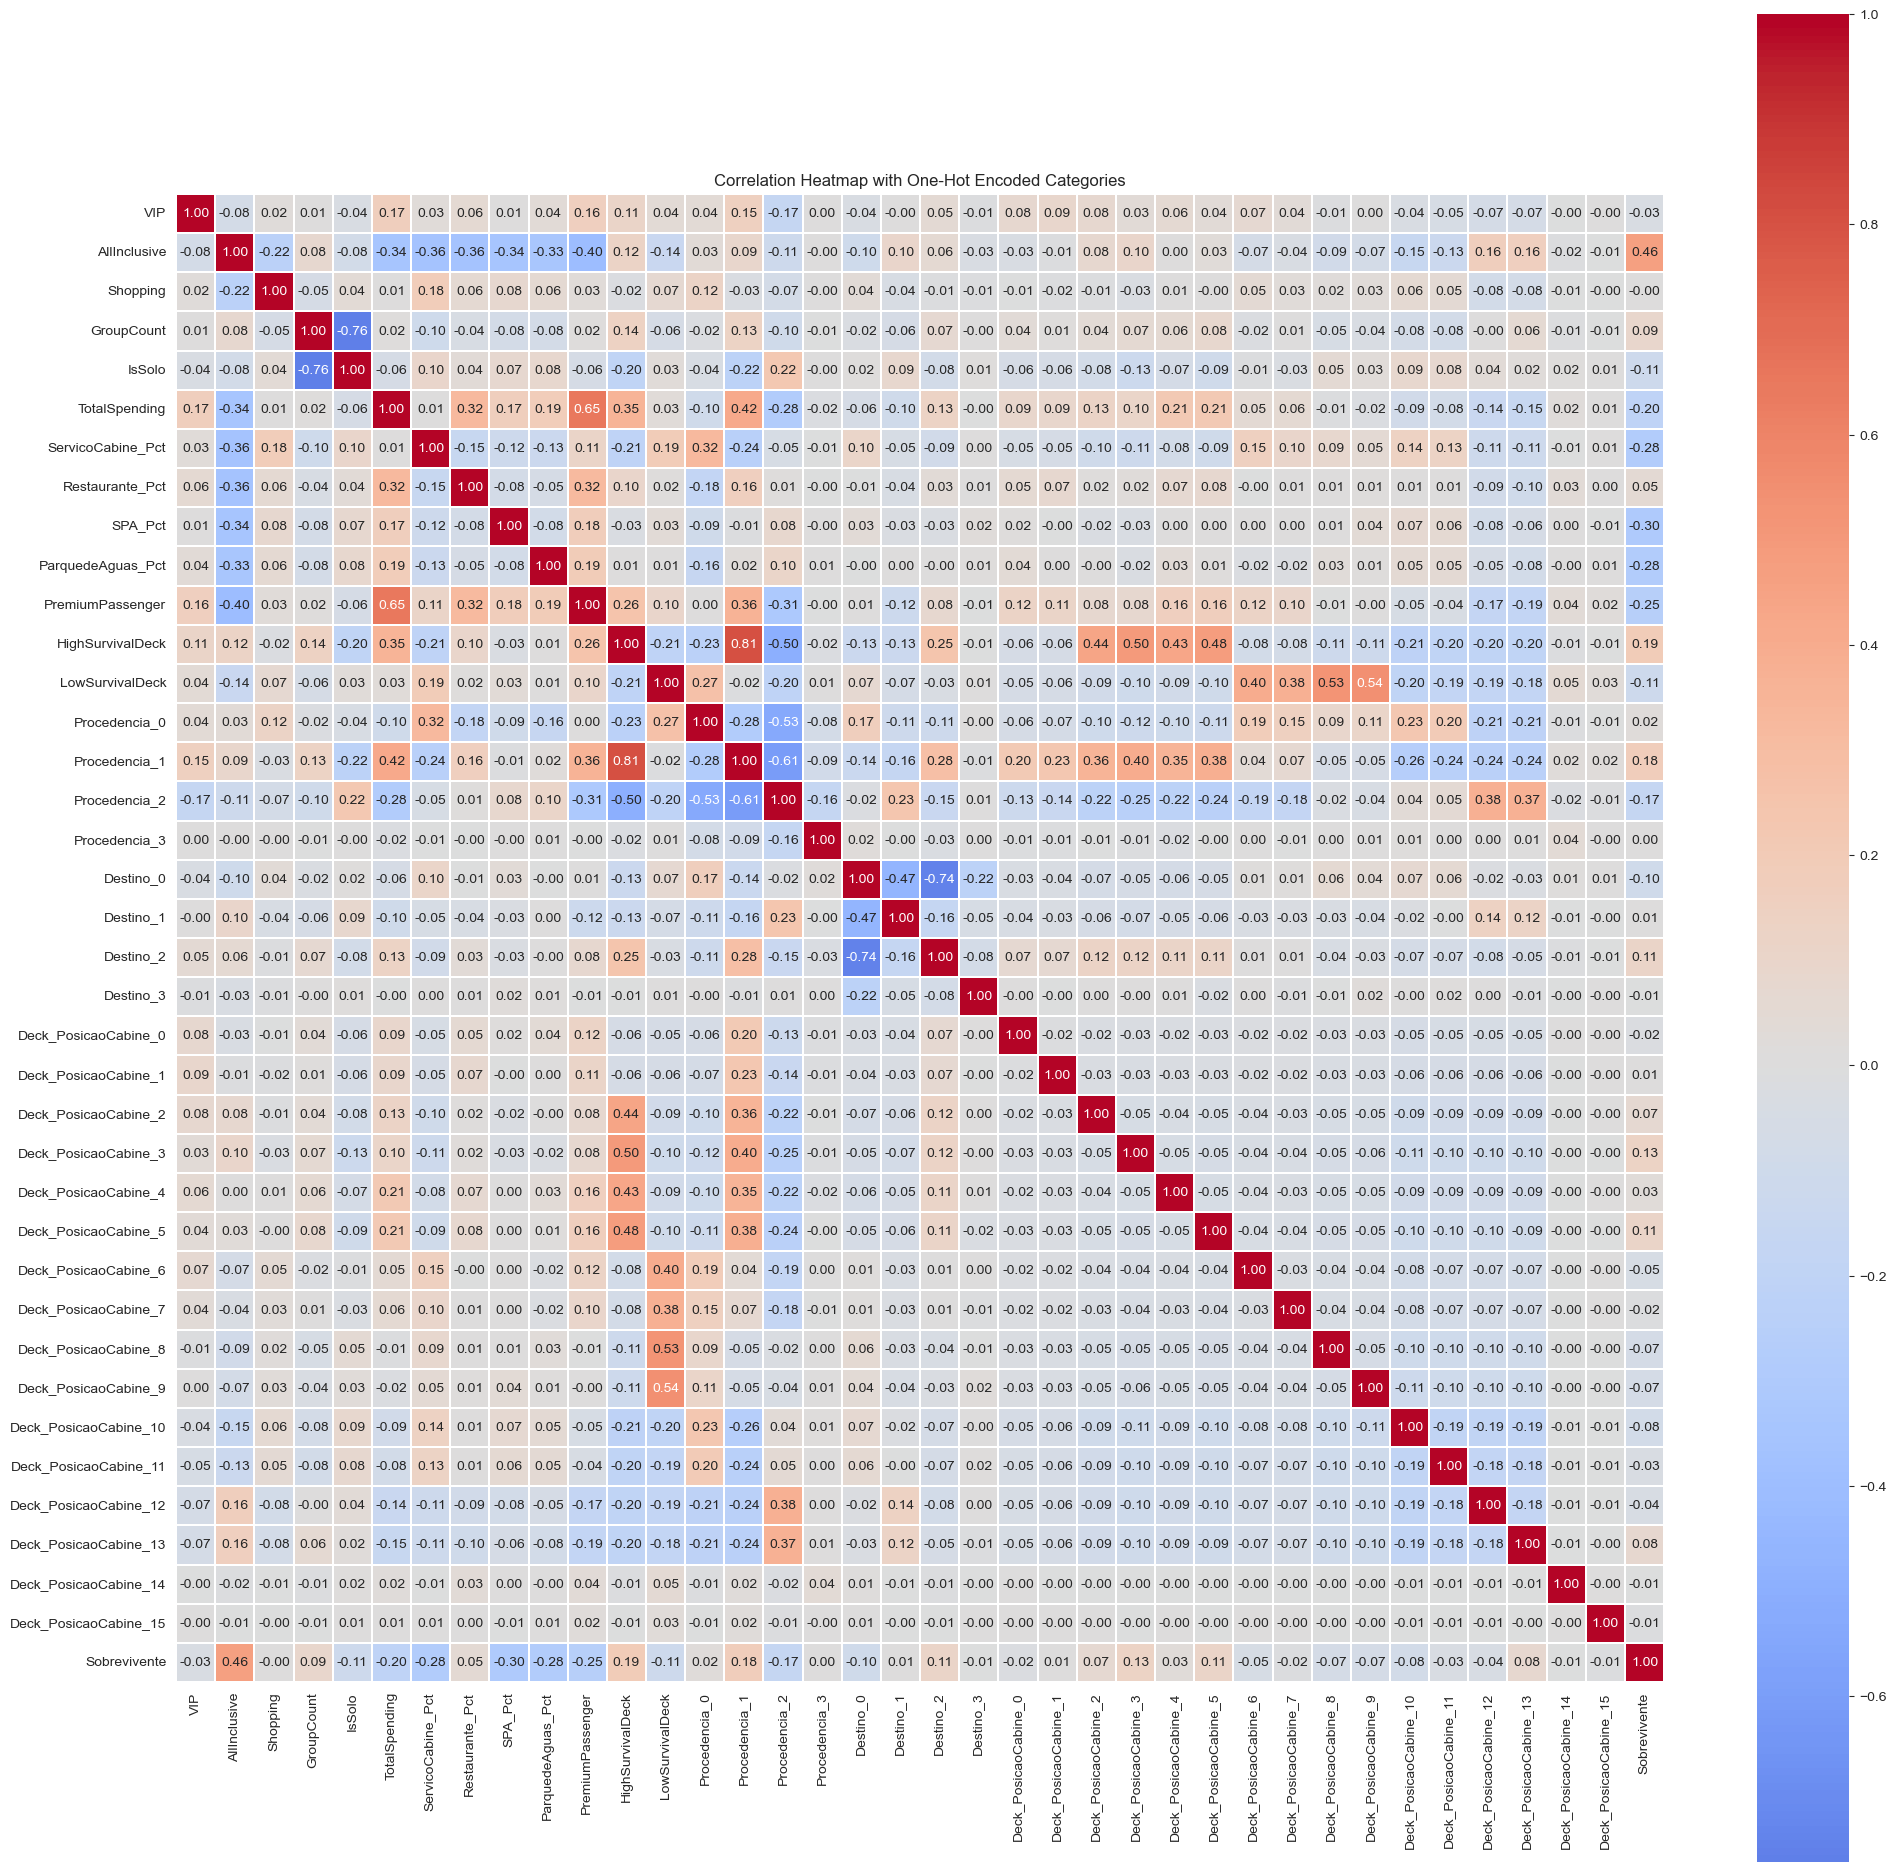

In [22]:
df_enc = df_aug.copy()
cat_cols = df_enc.select_dtypes(include=['object', 'category']).columns
for col in cat_cols:
    df_enc[col] = df_enc[col].astype('category').cat.codes
    one_hot = pd.get_dummies(df_enc[col], prefix=col, prefix_sep='_')
    df_enc = df_enc.drop(columns=[col])
    df_enc = pd.concat([df_enc, one_hot], axis=1)
corr = df_enc.corr()
cols = [col for col in corr.columns if col != 'Sobrevivente'] + ['Sobrevivente']
corr = corr.loc[cols, cols]
plt.figure(figsize=(24, 24))
sns.heatmap(
    corr,
    annot=True,
    cmap='coolwarm',
    center=0,
    fmt='.2f',
    square=True,
    linewidths=0.3,
)
plt.title('Correlation Heatmap with One-Hot Encoded Categories')
plt.show()

---
# Models

Now let's train some models and see how they perform.

As a quick spoiler: data augmentation and feature engineering didn't help much, so we will use the original dataset.
The data augmentation and feature engineering sections are here for completeness' sake.

In [23]:
import warnings
from dataclasses import dataclass
from typing import Optional

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import (
    accuracy_score,
    auc,
    confusion_matrix,
    f1_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

warnings.filterwarnings('ignore')

@dataclass
class Model:
    name: str
    params: dict[str, list]
    model: type[BaseEstimator]
    grid_search: Optional[GridSearchCV] = None

    def __post_init__(self):
        params = self.params.copy()
        self.params.clear()
        for k, v in params.items():
            self.params[f'classifier__{k}'] = v

        self.set_defaults()

    def set_defaults(self):
        model_params = self.model._get_param_names()

        if 'random_state' in model_params:
            self.params['classifier__random_state'] = [42]

        if 'n_jobs' in model_params:
            self.params['classifier__n_jobs'] = [-1]

        if 'max_iter' in model_params:
            self.params['classifier__max_iter'] = [50_000, 500_000]

    def set_defaults_instance(self, instance):
        model_params = instance._get_param_names()

        if 'random_state' in model_params:
            instance.random_state = 42

        if 'n_jobs' in model_params:
            instance.n_jobs = -1

        if 'max_iter' in model_params:
            instance.max_iter = 5_000


class AugmentationTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_aug = X.copy()

        spending_cols = ['ServicoCabine', 'Restaurante', 'SPA', 'ParquedeAguas']

        X_aug["TotalSpending"] = X_aug[spending_cols].sum(axis=1)
        total_spending = X_aug['TotalSpending'].replace(0, 1)  # Avoid division by zero
        for col in spending_cols:
            X_aug[f'{col}_Pct'] = X_aug[col] / total_spending * 100

        X_aug["PremiumPassenger"] = (X_aug["TotalSpending"] > X_aug["TotalSpending"].mean()).astype(int)
        X_aug["HighSurvivalDeck"] = X_aug["Deck"].isin(['B', 'C']).astype(int)
        X_aug["LowSurvivalDeck"] = X_aug["Deck"].isin(['D', 'E', 'T']).astype(int)
        X_aug['Deck_PosicaoCabine'] = df['Deck'] + "_" + df['PosicaoCabine']

        return X_aug.drop(columns=spending_cols + ['Deck', 'PosicaoCabine'], errors='ignore')

In [24]:
df.head()

Deck  NumeroCabine PosicaoCabine Procedencia Destino  Idade  VIP  \
0    C           178             P     America  Monaco   52.0    0   
1    D             2             S      Africa  Grecia   21.0    0   
2    E           273             S      Europa  Grecia   27.0    0   
3    E            95             S     America  Grecia   28.0    0   
4    B           297             P     America  Monaco   29.0    0   

   AllInclusive  ServicoCabine  Restaurante  Shopping    SPA  ParquedeAguas  \
0             0            0.0       1425.0      31.0    0.0         1320.0   
1             0         1743.0          5.0      17.0    0.0            0.0   
2             0            0.0          0.0     580.0  211.0            0.0   
3             1            0.0          0.0       0.0    0.0            0.0   
4             0            0.0      12563.0       0.0    3.0         5057.0   

   Sobrevivente GroupID  GroupCount  IsSolo AgeGroup  
0             1    5647           3   False    51-60  
1             0    0107           1    True    19-30  
2             0    4158           1    True    19-30  
3             1    1316           2   False    19-30  
4             0    9069           3   False    19-30

In [25]:
df = df.drop(["Shopping", "NumeroCabine", "GroupID"], errors="ignore", axis=1)
df.head()

Deck PosicaoCabine Procedencia Destino  Idade  VIP  AllInclusive  \
0    C             P     America  Monaco   52.0    0             0   
1    D             S      Africa  Grecia   21.0    0             0   
2    E             S      Europa  Grecia   27.0    0             0   
3    E             S     America  Grecia   28.0    0             1   
4    B             P     America  Monaco   29.0    0             0   

   ServicoCabine  Restaurante    SPA  ParquedeAguas  Sobrevivente  GroupCount  \
0            0.0       1425.0    0.0         1320.0             1           3   
1         1743.0          5.0    0.0            0.0             0           1   
2            0.0          0.0  211.0            0.0             0           1   
3            0.0          0.0    0.0            0.0             1           2   
4            0.0      12563.0    3.0         5057.0             0           3   

   IsSolo AgeGroup  
0   False    51-60  
1    True    19-30  
2    True    19-30  
3   False    19-30  
4   False    19-30

In [26]:
X = df.drop('Sobrevivente', axis=1)
y = df['Sobrevivente']

# NOTE If checking for spending etc:
# num_cols = ["Idade", "TotalSpending"]
# num_cols.extend([col for col in df_aug.columns if col.endswith('_Pct')])
# # cat_cols = ["Deck", "PosicaoCabine", "Procedencia", "Destino"]
# binary_cols = ["AllInclusive", "VIP", "HighSurvivalDeck", "LowSurvivalDeck", "PremiumPassenger"]

# NOTE If using the augmentation transformer:
# num_cols = X.select_dtypes(include=np.number).columns.drop(['VIP', 'AllInclusive', 'ServicoCabine', 'Restaurante', 'SPA', 'ParquedeAguas']).tolist() + ['TotalSpending'] + [col for col in df_aug.columns if '_Pct' in col]
# cat_cols = X.select_dtypes(include=['object', 'category']).columns.drop(['Procedencia', 'Destino']).tolist()
# binary_cols = ["AllInclusive", "VIP", "PremiumPassenger", "HighSurvivalDeck", "LowSurvivalDeck"]

# NOTE Incredibly, using all columns seems to work best
num_cols = X.select_dtypes(include=np.number).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
binary_cols = ["AllInclusive", "VIP"]

In [27]:
num_cols, cat_cols, binary_cols

(['Idade',
  'VIP',
  'AllInclusive',
  'ServicoCabine',
  'Restaurante',
  'SPA',
  'ParquedeAguas',
  'GroupCount'],
 ['Deck', 'PosicaoCabine', 'Procedencia', 'Destino', 'AgeGroup'],
 ['AllInclusive', 'VIP'])

In [28]:
column_transformer = ColumnTransformer(
        transformers=[
            ('num', Pipeline([('scaler', StandardScaler())]), num_cols),
            ('cat', Pipeline([('onehot', OneHotEncoder())]), cat_cols),
            ('binary', 'passthrough', binary_cols)
        ],
        n_jobs=-1,
        remainder='drop'
    )

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [29]:
import time

import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif

models = [
    Model(
        'Logistic Regression',
        {
            'C': [0.001, 0.01, 0.1, 1, 10],
            'penalty': ['l1', 'l2'],
            'solver': ['lbfgs', 'sag', 'saga'],
        },
        LogisticRegression,
    ),
    Model(
        'Random Forest',
        {
            'n_estimators': [100, 400],
            'max_depth': [5, 10],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [2, 4, 10],
            'max_features': ['sqrt', 'log2'],
        },
        RandomForestClassifier,
    ),
    Model(
        'Gradient Boosting',
        {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.001, 0.01, 0.1, 0.20],
            'max_depth': [3, 5, 7],
        },
        GradientBoostingClassifier
    ),
    Model(
        'Naive Bayes',
        {
            'var_smoothing': [1e-9, 1e-10, 1e-11, 1e-12],
        },
        GaussianNB
    ),
    Model(
        'KNN',
        {
            'n_neighbors': [3, 5, 7, 9, 11],
            'weights': ['uniform', 'distance'],
        },
        KNeighborsClassifier
    ),
    Model(
        'XGBoost',
        {
            'n_estimators': [100, 500, 1000],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.001, 0.01, 0.1, 0.20],
            'eval_metric': ['logloss'],
        },
        xgb.XGBClassifier
    ),
    Model(
        'SVC',
        {
            'C': [0.1, 1, 10],
            'tol': [1e-3, 1e-2],
            'gamma': ['scale', 'auto'], 
            'kernel': ['rbf', 'linear', 'sigmoid'], 
        },
        SVC,
    ),
    Model(
        'SGD Classifier',
        {
            'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
            'penalty': ['l1', 'l2'],
            'loss': ['hinge', 'perceptron', 'log_loss', 'modified_huber'],
        },
        SGDClassifier,
    ),
    Model(
        'MLP Classifier',
        {
            'hidden_layer_sizes': [(50,), (100,), (50, 50)],
            'activation': ['relu'],
            'solver': ['adam'],
            'learning_rate': ['constant', 'adaptive'],
            'alpha': [0.0001, 0.001, 0.01, 0.1],
        },
        MLPClassifier,
    )
]

First let's see how the base models (i.e. without any parameter optimization) perform.

In [30]:
for model in models:
    print(f'Training {model.name}...')
    start_time = time.time()

    pipeline = Pipeline([
        # ('augmentation', AugmentationTransformer()),
        ('preprocessor', column_transformer),
        ('feature_selection', SelectKBest(score_func=f_classif, k='all')),
        ('classifier', model.model())
    ], memory=None)

    pipeline.fit(X_train, y_train)
    model.__setattr__('default_pipeline', pipeline)

    elapsed_time = time.time() - start_time
    print(f'Finished {model.name} in {elapsed_time:.2f} seconds ({elapsed_time/60:.2f} minutes)')


Training Logistic Regression...
Finished Logistic Regression in 0.96 seconds (0.02 minutes)
Training Random Forest...
Finished Random Forest in 1.35 seconds (0.02 minutes)
Training Gradient Boosting...
Finished Gradient Boosting in 1.24 seconds (0.02 minutes)
Training Naive Bayes...
Finished Naive Bayes in 0.61 seconds (0.01 minutes)
Training KNN...
Finished KNN in 0.03 seconds (0.00 minutes)
Training XGBoost...
Finished XGBoost in 0.84 seconds (0.01 minutes)
Training SVC...
Finished SVC in 0.75 seconds (0.01 minutes)
Training SGD Classifier...
Finished SGD Classifier in 0.06 seconds (0.00 minutes)
Training MLP Classifier...
Finished MLP Classifier in 4.35 seconds (0.07 minutes)


In [31]:
for model in models:
    print(f'Training {model.name}...')
    start_time = time.time()

    pipeline = Pipeline([
        # ('augmentation', AugmentationTransformer()),
        ('preprocessor', column_transformer),
        ('feature_selection', SelectKBest(score_func=f_classif, k='all')),
        ('classifier', model.model())
    ], memory=None)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(
        pipeline,
        model.params,
        cv=skf,
        scoring=['recall', 'roc_auc', 'f1'],
        refit='roc_auc',
        n_jobs=-1,
    )

    grid_search.fit(X_train, y_train)
    model.grid_search = grid_search

    elapsed_time = time.time() - start_time
    print(f'Finished {model.name} in {elapsed_time:.2f} seconds ({elapsed_time/60:.2f} minutes)')

Training Logistic Regression...
Finished Logistic Regression in 14.54 seconds (0.24 minutes)
Training Random Forest...
Finished Random Forest in 45.82 seconds (0.76 minutes)
Training Gradient Boosting...
Finished Gradient Boosting in 38.70 seconds (0.65 minutes)
Training Naive Bayes...
Finished Naive Bayes in 0.30 seconds (0.00 minutes)
Training KNN...
Finished KNN in 1.17 seconds (0.02 minutes)
Training XGBoost...
Finished XGBoost in 16.28 seconds (0.27 minutes)
Training SVC...


/home/debem/mambaforge/envs/ml/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/debem/mambaforge/envs/ml/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/debem/mambaforge/envs/ml/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/debem/mambaforge/envs/ml/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/debem/mambaforge/envs/ml/lib/python3.11/site-p

Finished SVC in 31.47 seconds (0.52 minutes)
Training SGD Classifier...
Finished SGD Classifier in 4.48 seconds (0.07 minutes)
Training MLP Classifier...
Finished MLP Classifier in 122.19 seconds (2.04 minutes)


In [32]:
@dataclass
class ModelResults:
    model: Model
    accuracy: float
    recall: float
    f1: float
    roc_auc: float

    @property
    def name(self) -> str:
        return self.model.name

    def to_dict(self) -> dict:
        return {
            'Model': self.name,
            'Accuracy': self.accuracy,
            'Recall': self.recall,
            'F1': self.f1,
            'ROC AUC': self.roc_auc
        }


def evaluate_models(models: list[Model], X: pd.DataFrame, y: pd.Series) -> pd.DataFrame:
    model_results: dict[str, ModelResults] = {}
    for model in models:
        if model.grid_search is None:
            print(f"Skipping {model.name} as it hasn't been trained yet")
            continue

        classifier = model.grid_search.best_estimator_
        y_pred = classifier.predict(X)  # type: ignore

        model_results[model.name] = ModelResults(model, **{
            'accuracy': accuracy_score(y, y_pred),
            'recall': recall_score(y, y_pred),
            'f1': f1_score(y, y_pred),
            'roc_auc': roc_auc_score(y, y_pred)
        })

    return pd.DataFrame([result.to_dict() for result in model_results.values()])

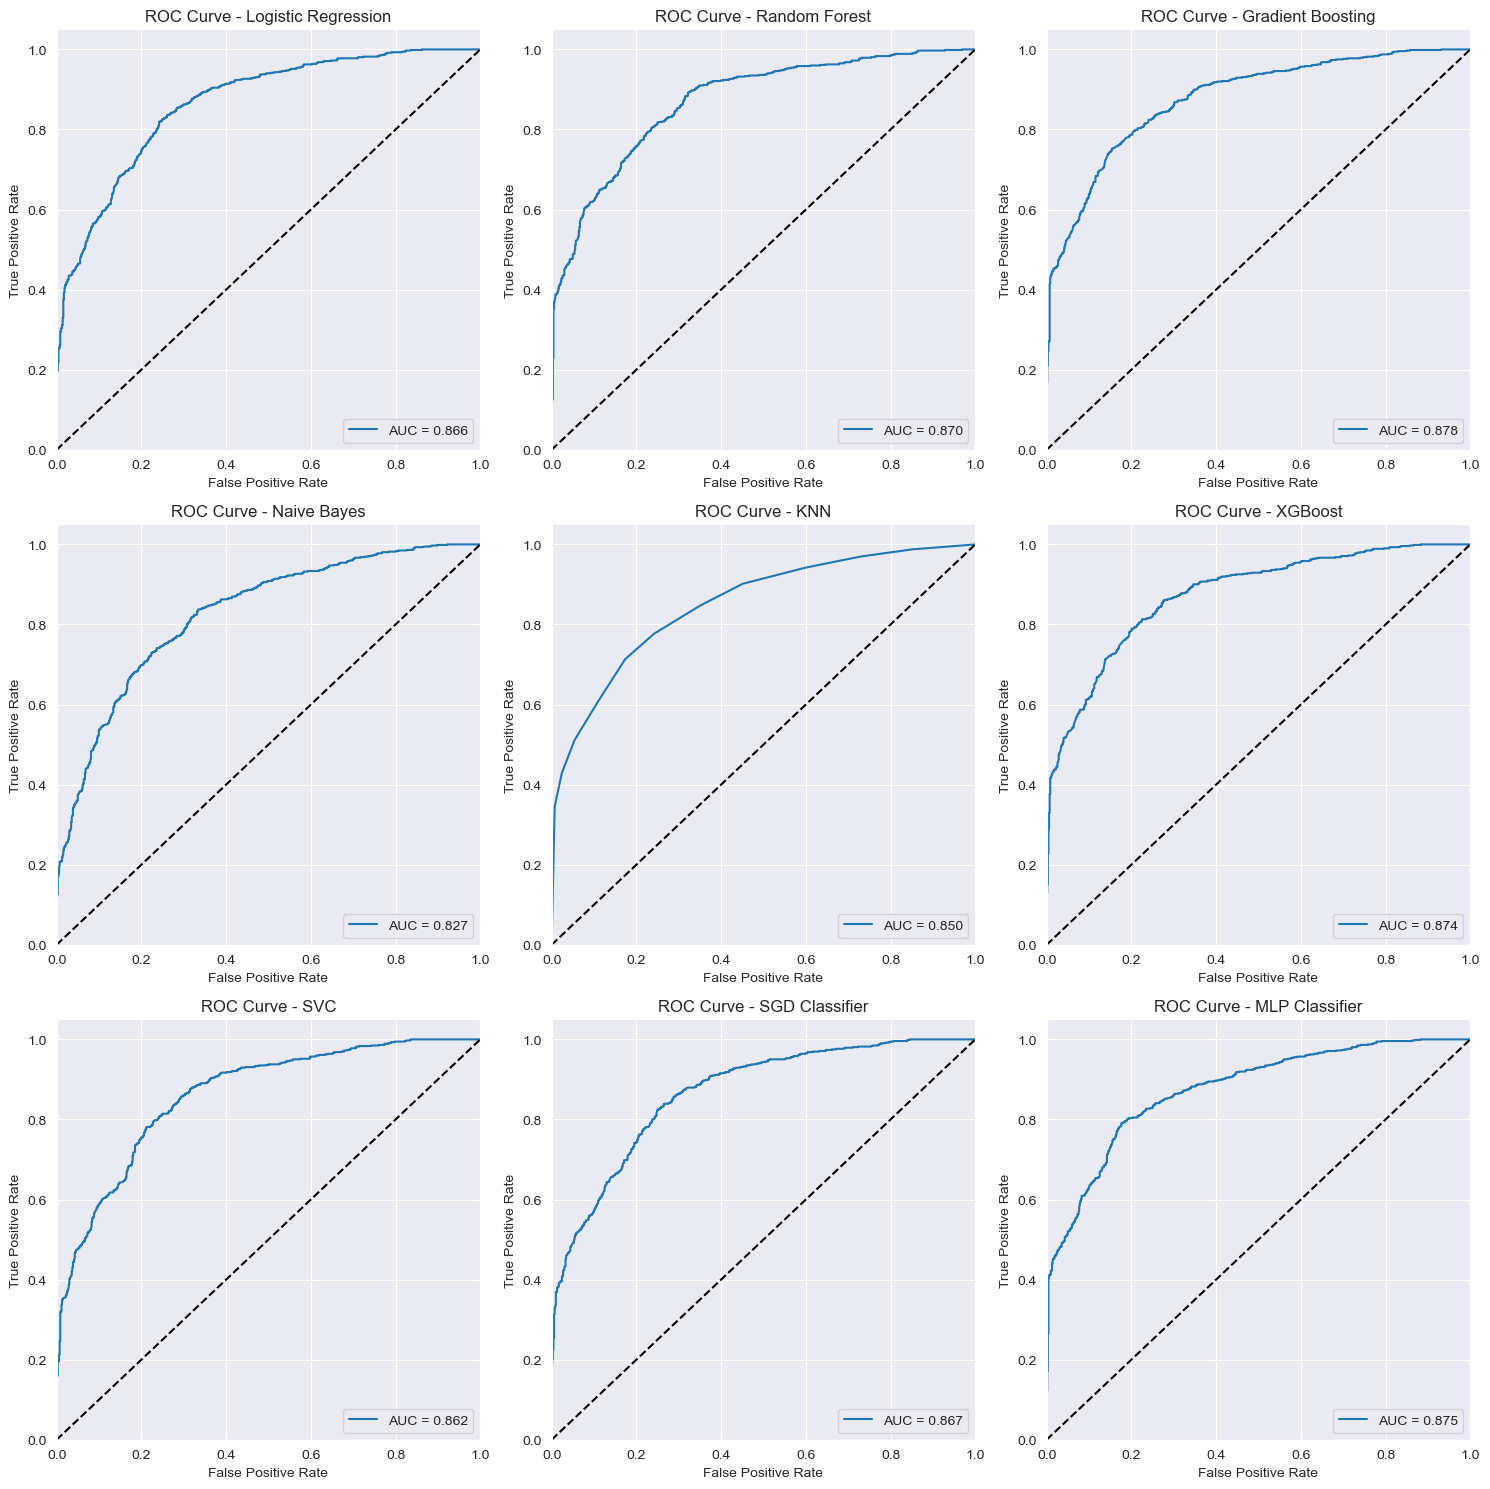

Model  Accuracy    Recall        F1   ROC AUC
5              XGBoost  0.788070  0.844875  0.801577  0.787303
2    Gradient Boosting  0.784561  0.843490  0.798689  0.783765
3          Naive Bayes  0.728421  0.869806  0.764455  0.726510
0  Logistic Regression  0.787368  0.836565  0.799471  0.786704
6                  SVC  0.779649  0.832410  0.792876  0.778936
8       MLP Classifier  0.796491  0.810249  0.801370  0.796305
7       SGD Classifier  0.777544  0.781163  0.780623  0.777495
4                  KNN  0.767719  0.777008  0.772195  0.767594
1        Random Forest  0.779649  0.765928  0.778873  0.779835

In [33]:
def plot_roc_curves_grid(models, X, y):
    n_models = len(models)
    n_cols = 3
    n_rows = int(np.ceil(n_models / n_cols))
    
    _ = plt.figure(figsize=(15, 5 * n_rows))
    
    for idx, model in enumerate(models):
        # Create subplot
        ax = plt.subplot(n_rows, n_cols, idx + 1)
        
        try:
            try:
                y_scores = model.grid_search.best_estimator_.predict_proba(X)[:, 1]
            except (AttributeError, IndexError): # For models like SVC without probability estimation
                y_scores = model.grid_search.best_estimator_.decision_function(X)

            fpr, tpr, _ = roc_curve(y, y_scores)
            roc_auc = auc(fpr, tpr)
            
            ax.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
            
            ax.plot([0, 1], [0, 1], 'k--')

            ax.set_xlim([0.0, 1.0])  # type: ignore
            ax.set_ylim([0.0, 1.05])  # type: ignore
            ax.set_xlabel('False Positive Rate')
            ax.set_ylabel('True Positive Rate')
            ax.set_title(f'ROC Curve - {model.name}')
            ax.legend(loc="lower right")
            ax.grid(True)

        except Exception as e:
            print(f"Error plotting ROC curve for {model.name}: {str(e)}")
            continue
    plt.tight_layout()
    plt.show()

def summary_results(model_results: pd.DataFrame, models, X: pd.DataFrame, y: pd.Series):
    plot_roc_curves_grid(models, X, y)

    df = model_results.copy()

    # Give a touch more weight to recall and sort by the weighted sum
    df['weighted_sum'] = (df['Recall'] * 0.55) + (df['F1'] * 0.45)
    display(df.sort_values('weighted_sum', ascending=False).drop(columns='weighted_sum'))

model_results_df = evaluate_models(models, X_test, y_test)
summary_results(model_results_df, models, X_test, y_test)

---

# Validation Data - Unknown Data

Now we're ready to make predictions on the validation data, which we don't have access to.
We need to first verify if the data file exists.

Then, we can load the data and make predictions using the best models we found.

Finally, we re-plot the ROC AUC curves for the models and print the results sorted by the weighted sum of the recall and F1 score.

In [34]:
# Check if 'teste.csv' exists
import os

if not os.path.exists('teste.csv'):
    raise FileNotFoundError('teste.csv not found')

df_validation = pd.read_csv('teste.csv')

X_val = df_validation.drop('Sobrevivente', axis=1)
y_val = df_validation['Sobrevivente']

model_results_val_df = evaluate_models(models, X_val, y_val)
summary_results(model_results_val_df, models, X_val, y_val)

FileNotFoundError: teste.csv not found